# Prepare data input for Amazon Forecast

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and enterprises need to estimate their cloud infrastructure needs.
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/forecast_overview.png" width="98%">

# Notebook Overview

This notebook provides a template of typical steps required to prepare data input for Amazon Forecast. So, this is part of "Upload your data to Amazon Forecast" in the diagram above.  Your data may need additional Prepare steps and/or you may not need all the steps in this notebook.<br>

<b>Step 2 Make forecast choices</b>. You need to make some decisions.  How many time units in future do you want to make forecasts?  E.g. if time unit is Hour, then if you want to forecast out 1 week that would be 24*7 = 168 hours.  You'll also be asked if you want integer or float target_values.  And if 0's really mean 0 or are they missing data?

<b>Step 10 Aggregate based on the time granularity of your data.</b> Possible aggregations are minute, hour, day, week, month.  See <a href="https://docs.aws.amazon.com/forecast/latest/dg/howitworks-datasets-groups.html#howitworks-data-alignment" target="_blank">documenatation. </a>

<b>Step 12 Visualization time series and validate the time granularity you chose makes sense.</b>  Too low-granularity means the time series looks like white noise and the data could benefit by aggregation at higher-time-level.  For example, you might start to notice time series cyclical patterns when aggregating historical sales by-hour instead of of by-minute.  Alternate between Step 7 Visualization and Step 5 Aggregation until you are happy with the chosen time-grandularity for your forecasts.

<b>Steps 10 (Aggregate) and 13 (Split train) include a set of common checks on your data for forecasting.</b> One common mistake is customers think they should "try Amazon Forecast with a small sample of data".  If the majority of your time series have fewer than 300 data points, Amazon Forecast will fail, because Amazon Forecast is designed for deep-learning AI forecasting algorithms, which require many data points (typically 1000+) per time series.  Small data is better off using traditional, open-source forecast methods such as ETS (available in Excel), ARIMA, or Prophet.  Small data is not a good fit for Amazon Forecast.  If you really want to try Amazon Forecast, but your data fails the Error Checks consider: 

<ul>
    <li>Can you get more data such that each time series will have longer history with more data points?  If so, return to Step 1.</li>
    <li>Can you combine items into fewer item_ids such that each time series will have longer history with more data points?  If so, return to Step 1.</li>
    <li>Can you reduce forecast dimensions, such as use item_id only and drop location_id?  If so, return to Step 5.</li>
    <li>Can you drop to a lower time-frequency without your data turning into white noise?  Check your data again using Step 10 Aggregate and Step 12 Visualize. </li>
</ul>
 
It may be that you find your data is not a good fit for Amazon Forecast.  In that case, it's better that you discover this early.

<b>In steps 14-21, we will save headerless Target Time Series (TTS), Item metadata (IM), Related Time Series (RTS) to S3</b> so we can trigger Amazon Forecast automation, see
    <a href="https://github.com/aws-samples/amazon-forecast-samples/tree/master/workshops/CloudFormationAutomation" target="_blank">Workshop Instructions Install Automation and Demo</a>

TODO:  bucket steps so list doesn't look so long! <br>
TODO:  Add data normalization step

# Table of Contents 
* Step 0: [Set up and install libraries](#setup)
* Step 1: [Read data](#read)
* Step 2: [Make forecast choices](#choices)
* Step 3: [Correct dtypes](#fix_dtypes)
* Step 4: [Drop null item_ids](#drop_null_items)
* Step 5: [Drop null timestamps](#drop_null_times) 
* Step 7: [Inspect and treat extremes](#treat_extremes) 
* Step 8: [Optional - Round negative targets up to 0](#round_negatives) 
* Step 9: [Optional - Convert negative targets to_nan](#negatives_to_nan) 
* Step 10: [Aggregate at chosen frequency](#groupby_frequency) 
* Step 11: [Typical Retail scenario: Find top-moving items](#top_moving_items)
* Step 12: [Visualize time series](#visualize) 
* Step 13: [Classify time series](#Classify)
* Step 14: [Split train/test data](#split_train_test)
* Step 15: [Prepare and save Target Time Series](#TTS) 
* Step 16: [Remove time series with no target values at all](#TTS_remove_all0)
* Step 17: [Remove time series with end of life](#TTS_remove_end_of_life)
* Step 18: [Remove time series with fewer than 5 data points](#TTS_remove_too_few_data_points)
* Step 19: [Optional - Assemble and save TTS_sparse, TTS_dense](#TTS-dense_sparse)
* Step 20: [Optional - Assemble and save TTS_top, TTS_slow](#TTS_top)
* Step 21: [Optional - Assemble and save TTS_regular, TTS_erratic, TTS_intermittent, TTS_lumpy](#TTS_classes)
* Step 22: [Assemble and save metadata (if any)](#IM) 
* Step 23: [Assemble and save RTS (if any)](#RTS)

## Data used in these notebooks: NYC Taxi trips open data

Given hourly historical taxi trips data for NYC, your task is to predict #pickups in next 7 days, per hour and per pickup zone.  <br>

<ul>
<li>Original data source:  <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page" target="_blank"> https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</a> </li>
<li>AWS-hosted public source:  <a href="https://registry.opendata.aws/nyc-tlc-trip-records-pds/" target="_blank">https://registry.opendata.aws/nyc-tlc-trip-records-pds/ </a> </li>
<li>AWS managed weather data ingestion as a service that is bundled with Amazon Forecast, aggregated by location and by hour.  Initially only for USA and Europe, but depending on demand, possibly in the future for other global regions. </li>
<li>Data used:  Yellow taxis dates: 2018-12 through 2020-02 to avoid COVID effects </li>
</ul>

 
### Features and cleaning
Note: ~5GB Raw Data has already been cleaned and joined using AWS Glue (tutorials to be created in future). 
<ul>
    <li>Join shape files Latitude, Longitude</li>
    <li>Add Trip duration in minutes</li>
    <li>Drop negative trip distances, 0 fares, 0 passengers, less than 1min trip durations </li>
    <li>Drop 2 unknown zones ['264', '265']
    </ul>

## Step 0:  Set up and install libraries <a class="anchor" id="setup"></a>

In [1]:
# Import standard open libraries
import os
import sys
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import time

print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
# display all rows
pd.set_option('display.max_rows', 1000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import random
import numpy as np
print('numpy: {}'.format(np.__version__))

import matplotlib as mpl
print('matplotlib: {}'.format(mpl.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
print('seaborn: {}'.format(sns.__version__))
# choose colorblind
color_pal = sns.color_palette("colorblind", 6).as_hex()
colorblind6 = ','.join(color_pal).split(",")

# AWS libraries and initialization
import boto3

pandas: 1.1.5
numpy: 1.19.5
matplotlib: 3.3.4
seaborn: 0.11.1


In [2]:
#########
# Functions to classify items as "top movers" or not
# TODO: generaize to handle any number of forecast dimensions, not just location
#########

def get_time_min_max(the_df, item_id_col, timestamp_col, location_id_col=None):
    """Calculate min timestamp, max timestamp per item and/or per item-location time series  
       Inputs: pandas dataframe with columns: timestamp, target_value, item_id, location_id (optional)
       Outputs: pandas dataframe with 2 extra columns "min_time" and "max_time"
    """
    df = the_df.copy()
    
    if location_id_col == None:
        # get max
        max_time_df = \
            df.groupby([item_id_col], as_index=False).max()[[item_id_col, timestamp_col]]
        max_time_df.columns = [item_id_col, 'max_time']
        # get min
        min_time_df = df.groupby([item_id_col], as_index=False).min()[[item_id_col, timestamp_col]]
        min_time_df.columns = [item_id_col, 'min_time']
        # merge 2 extra columns per item grouping: max and min
        df = df.merge(right=max_time_df, on=item_id_col)
        df = df.merge(right=min_time_df, on=item_id_col)
        
    else:
        # get max
        max_time_df = \
            df.groupby([item_id_col, location_id_col], as_index=False).max()[[item_id_col, location_id_col, timestamp_col]]
        max_time_df.columns = [item_id_col, location_id_col, 'max_time']
        # get min
        min_time_df = df.groupby([item_id_col, location_id_col], as_index=False).min()[[item_id_col, location_id_col, timestamp_col]]
        min_time_df.columns = [item_id_col, location_id_col, 'min_time']
        # merge 2 extra columns per item grouping: max and min
        df = df.merge(right=max_time_df, on=[item_id_col, location_id_col])
        df = df.merge(right=min_time_df, on=[item_id_col, location_id_col])
        
    return df


def get_velocity_per_item(the_df, timestamp_col, target_value_col, item_id_col, location_id_col=None):
    """Calculate velocity as target_demand per time unit per time series
       Inputs: pandas dataframe with columns: timestamp, target_value, item_id, location_id (optional)
       Outputs: pandas dataframe with extra "velocity" column
    """
    df = the_df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%Y-%m-%d %H:%M:%S')
    
    # append 2 extra columns per time seres: min_time, max_time
    if location_id_col == None:
        df = get_time_min_max(the_df, item_id_col, timestamp_col)
    else:
        df = get_time_min_max(the_df, item_id_col, timestamp_col, location_id_col)
        
#     print (df.sample(10))
    
    # calculate time span per time seres
    df['time_span'] = df['max_time'] - df['min_time']
    df['time_span'] = df['time_span'].apply(lambda x: x.seconds / 3600 + 1) # add 1 to include start datetime and end datetime
    
    # calculate average item demand per time unit
    if location_id_col == None:
        df = df.groupby([item_id_col], as_index=False).agg({'time_span':'mean', target_value_col:'sum'})
    else:
        df = df.groupby([item_id_col, location_id_col], as_index=False).agg({'time_span':'mean', target_value_col:'sum'})
    df['velocity'] = df[target_value_col] / df['time_span']
    
    return df

def get_top_moving_items(the_df
                           , timestamp_col
                           , target_value_col
                           , item_id_col
                           , location_id_col=None):
    """Calculate mean velocity over all items as "criteria".
       Where velocity is demand per time unit per time series
       Assign each item into category "top" or not depending on whether its velocity > criteria.
       Return 4 dataframes:  top_moving and slow_moving items; top_moving and slow_moving time series
    """
    
    # calculate item-level velocity
    df_items_velocity = the_df.copy().reset_index(drop=True)
    df_items_velocity = get_velocity_per_item(df_items_velocity, timestamp_col
                                           , target_value_col, item_id_col)
    # calculate ts-level velocity
    if location_id_col is not None:
        df_ts_velocity = the_df.copy().reset_index(drop=True)
        df_ts_velocity = get_velocity_per_item(df_ts_velocity, timestamp_col
                                               , target_value_col, item_id_col, location_id_col)
    else:
        print("No location found")
        df_ts_velocity = pd.DataFrame()
    
    #########
    # define cut=off criteria for "top-moving" vs "slow-moving" time series
    if location_id_col is None:
        criteria = df_items_velocity['velocity'].mean()
    else:
        criteria = df_ts_velocity['velocity'].mean()
        # define top-moving if velocity > criteria
        df_ts_velocity['top_moving'] = df_ts_velocity['velocity'] > criteria
        print('average velocity of all items:', criteria)
    #########
    
    # define top-moving if velocity > criteria
    df_items_velocity['top_moving'] = df_items_velocity['velocity'] > criteria
    
    return df_items_velocity, df_ts_velocity


#########
# Function to classify time series
#########

def calc_ADI(theDF, time_col, item_col, target_col):
    """    
    Calculates class of time series
    Input: theDF = pandas dataframe already grouped as single item at a time
    Ouptu: pandas dataframe with 2 extra columns 'ADI' and 'ts_type'
    Rules:
    1. Regular demand (ADI < 1.32 and CV² < 0.49). 
    2. Intermittent demand (ADI >= 1.32 and CV² < 0.49). 
    3. Erratic demand (ADI < 1.32 and CV² >= 0.49). 
    4. Lumpy demand (ADI >= 1.32 and CV² >= 0.49). Unforecastable.
    """
    df = theDF.copy()
    
    # calculate ADI
    num_periods = df[time_col].nunique()
    num_demands_missing = df[target_col].isna().sum()
    num_demands = num_periods - num_demands_missing
    ADI = num_periods / num_demands
    df['ADI'] = ADI
    
    # calculate CV, coefficient of variation = std of population / mean value of population
    CV = df.loc[(df[target_col]>0), target_col].std() / df.loc[(df[target_col]>0), target_col].mean()
    df['CV'] = CV
    
    # apply rules
    df['ts_type'] = 'regular'
    if ((ADI < 1.32) & (CV < 0.49)):
        df['ts_type'] = 'regular'
    elif ((ADI >= 1.32) & (CV < 0.49)):
        df['ts_type'] = 'intermittent'     
    elif ((ADI < 1.32) & (CV >= 0.49)):
        df['ts_type'] = 'erratic'  
    elif ((ADI >= 1.32) & (CV >= 0.49)):
        df['ts_type'] = 'lumpy'  
        
#     print(f"check: item = {df.head(1)[item_col].unique()}, ADI={ADI}, type = {df['ts_type'].unique()}")
    return df


#########
# Function to plot time series
#########

def make_plots(theDF, use_location, sample_items, sample_locations=[]):
    """
    """
    
    # select range to zoom-in on particular time event
    zoomed = theDF.copy()
    # zoomed = zoomed["2019-01-06":"2019-12-31"].copy()
    
    # separate plot for each item_id
    if use_location:
        num_plots = len(sample_items) * len(sample_locations)
    else:
        num_plots = len(sample_items)
       
    # resize plots smaller if fewer time series to plot
    if num_plots >= 5:    
        fig, axs = plt.subplots(num_plots, 1, figsize=(15, 15), sharex=True)
    elif num_plots > 1:
        fig, axs = plt.subplots(num_plots, 1, figsize=(15, 8), sharex=True)
    else:
        # default at least 2 plots otherwise axs indexing breaks
        fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    # fig.subplots_adjust(hspace=0.5) # pad a little if each x-axis has title
    
    plot_num = 0
    for i in range(len(sample_items)):
        # plot the item_id's target_value
        item = sample_items[i]

        # plot item_id, location_id's target value
        if use_location:
            location = sample_locations[i]
            zoomed2 = zoomed.loc[((zoomed[item_id]==item) & (zoomed[location_id]==location)), :].copy()
        else:
            zoomed2 = zoomed.loc[((zoomed[item_id]==item)), :].copy()

        # plot only if time series exists
        if zoomed2.shape[0] > 0:

            # plot target_value 
            zoomed2[[target_value]].plot(ax=axs[plot_num])

            # set title for each subplot
            if use_location:
                axs[plot_num].set_title(f"item {item} and location {location}")  
            else:
                axs[plot_num].set_title(f"item {item}")  
            fig.text(0.04, 0.5, 'Monthly quantity', va='center', rotation='vertical')

            # format the x-axis
            axs[plot_num].set_xlabel("Timestamp")  # set x-axis title
            axs[plot_num].xaxis.label.set_visible(False)

            # remove each individual subplot legend
            axs[plot_num].get_legend().remove()

            # format the grid
            axs[plot_num].grid(False)
            axs[plot_num].grid(which='major', axis='x')

            # increment plot counter
            plot_num = plot_num + 1

    plt.plot();

<b>Create a new S3 bucket for this lesson</b>
- The cell below will create a new S3 bucket with name ending in "forecast-demo-taxi"

In [3]:
# create unique S3 bucket for saving your own data
region = boto3.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

# TODO put new bucket name back
bucket_name = "christy-forecast"  #default account_id + '-forecast-demo-taxi'
prefix = "open-data-analytics-taxi-trips"
# if util.create_bucket(bucket_name, region=region):
#     print(f"Success! Created bucket {bucket_name}")
print(bucket_name)

christy-forecast


In [4]:
# Connect API sessions
session = boto3.Session(region_name=region) 
s3 = session.client(service_name='s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [5]:
# check you can communicate with Forecast APIs
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:us-west-2:938097332257:predictor/nyctaxi_demo2_snap02232020_168H_2021_04_11_03_50_28',
   'PredictorName': 'nyctaxi_demo2_snap02232020_168H_2021_04_11_03_50_28',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:938097332257:dataset-group/nyctaxi_demo2_snap02232020_168H',
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2021, 4, 11, 3, 50, 58, 519000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2021, 4, 11, 23, 55, 37, 428000, tzinfo=tzlocal())},
  {'PredictorArn': 'arn:aws:forecast:us-west-2:938097332257:predictor/agrvivek_parts_automl',
   'PredictorName': 'agrvivek_parts_automl',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:938097332257:dataset-group/agrvivek_parts',
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2021, 4, 5, 22, 31, 58, 357000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2021, 4, 6, 2, 29, 25, 947000, tzinfo=tzlocal())},
  {'PredictorArn': 'arn:aws

<b>Create IAM Role for Forecast</b> <br>
Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In the sample notebooks, we use the get_or_create_iam_role() utility function to create an IAM role. Please refer to "notebooks/common/util/fcst_utils.py" for implementation.

In [6]:
# TODO put new IAM role back

# # Create the role to provide to Amazon Forecast.
# role_name = "ForecastNotebookRole-Basic"
# print(f"Creating Role {role_name} ...")
# role_arn = util.get_or_create_iam_role( role_name = role_name )
role_arn = "arn:aws:iam::938097332257:role/service-role/AWSGlueServiceSageMakerNotebookRole-nytaxi-notebook"

# echo user inputs without account
print(f"Success! Created role arn = {role_arn.split('/')[1]}")

Success! Created role arn = service-role


## Step 1. Read data <a class="anchor" id="read"></a>

The first thing we're going to do is read the headerless .csv file.  Then we need to identify which columns map to required Amazon Forecast inputs.

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/nyctaxi_map_fields.png" width="82%">
<br>

<b>In order to use Weather Index, you need a geolocation-type column.</b>  The geolocation-type column connects your locations to geolocations, and can be 5-digit postal code or latitude_longitude.  For more details, see:
<ul>
    <li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html" target="_blank">Link to documentation about geolocations</a></li>
    <li><a href="https://aws.amazon.com/blogs/machine-learning/amazon-forecast-weather-index-automatically-include-local-weather-to-increase-your-forecasting-model-accuracy/" target="_blank">Our Weather blog, which shows UI steps.</a></li>
</ul>

The cell below shows an example reading headerless csv file with lat_lon geolocation column, "pickup_geolocation".  The rest of this notebook writes headerless csv files to be able to use automation.  If you are not planning on using the automation solution, .csv files with headers are allowed.

In [7]:
## Read cleaned, joined, featurized data from Glue ETL processing
df_raw = pd.read_csv("s3://amazon-forecast-samples/data_prep_templates/clean_features.csv"
                          , parse_dates=True
                          , header=None
                          , dtype={0:'str'
                                   , 1: 'str'
                                   , 2: 'str'
                                   , 3:'str'
                                   , 4: 'int32'
                                   , 5: 'float64'
                                   , 6: 'str'
                                   , 7: 'str'
                                   , 8: 'str'}
                          , names=['pulocationid', 'pickup_hourly', 'pickup_day_of_week'
                                   , 'day_hour', 'trip_quantity', 'mean_item_loc_weekday'
                                   , 'pickup_geolocation', 'pickup_borough', 'binned_max_item'])

# drop duplicates
print(df_raw.shape)
df_raw.drop_duplicates(inplace=True)

df_raw['pickup_hourly'] = pd.to_datetime(df_raw["pickup_hourly"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
print(df_raw.shape)
print(df_raw.dtypes)
start_time = df_raw.pickup_hourly.min()
end_time = df_raw.pickup_hourly.max()
print(f"Min timestamp = {start_time}")
print(f"Max timestamp = {end_time}")
df_raw.sample(5)

(1507488, 9)
(1507488, 9)
pulocationid                     object
pickup_hourly            datetime64[ns]
pickup_day_of_week               object
day_hour                         object
trip_quantity                     int32
mean_item_loc_weekday           float64
pickup_geolocation               object
pickup_borough                   object
binned_max_item                  object
dtype: object
Min timestamp = 2019-07-01 00:00:00
Max timestamp = 2020-02-29 23:00:00


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
1399963,51,2019-10-29 00:00:00,Tuesday,Tuesday_0,0,1.23977,40.87406155_-73.83042363,Bronx,Cat_1
74742,129,2019-07-23 01:00:00,Tuesday,Tuesday_1,4,3.10456,40.75905747_-73.88740638,Queens,Cat_1
974940,215,2019-12-06 11:00:00,Friday,Friday_11,3,1.91935,40.6941903_-73.79036754,Queens,Cat_1
1026547,172,2019-12-10 17:00:00,Tuesday,Tuesday_17,0,1.00000,40.57246542_-74.1039265,Staten Island,Cat_1
970649,126,2020-01-18 18:00:00,Saturday,Saturday_18,1,1.27711,40.81391819_-73.88497727,Bronx,Cat_1


In [8]:
# map expected column names
item_id = "pulocationid"
target_value = "trip_quantity"
timestamp = "pickup_hourly"
location_id = "pickup_geolocation"

In [9]:
original_shape = df_raw.shape 
original_shape

(1507488, 9)

## Step 2. Make forecast choices <a class="anchor" id="choices"></a>

Below, you need to make some choices.  First, you will be asked how you want to treat target values (the values you're forecasting). 
<ol>
    <li><b>Do you want your target values to be floating point numbers or integers?</b>  If you choose floating point numbers, you won't be able to use negative-binomial distribution later in the DeepAR+ algorithm.  If you don't care about that, then just hit enter to accept the default, which is floats. </li>
    <li><b>Decide if you want to round 0's to nulls.</b>  If you believe in your data '0' really means '0', then just hit enter to accept the default of do nothing to 0's.  On the other hand, if you think some of your 0's were missing data instead of actual 0's, then opt-in by typing 'yes' to convert 0's to nulls. </li>
    <li><b>Decide if you want to automatically impute missing categorical fields?</b> If you think you only have a few missing values, you might impute missing values to be the top category.</li>
    <li><b>Decide if you want to replace extreme values with mean?</b>  If you think you only have one or two extreme values it might make sense to replace them. On the other hand, if you have quite a few, that is indication those values are not really extreme.</li>
    <li><b>Do you want to generate future RTS that extends into future?</b>  If you set this to True, all data will be used for Training.  If you set it to False, a hold-out of length Forecast Horizon will be used to alculte RTS.</li>
    <li><b>How many time units do you want to forecast?</b>. For example, if your time unit is Hour, then if you want to forecast out 1 week, that would be 24*7 = 168 hours, so answer = 168. </li>
    <li><b>What is the time granularity for your data?</b>. For example, if your time unit is Hour, answer = "H". </li>
    <li><b>What is the first date you want to forecast?</b>  Training data will be cut short 1 time unit before the desired first forecast snapshot date.  For example, if the granularity of your data is "D" and you want your first forecast to happen on Feb 8, 2019, then the last timestamp for training will be Feb 7, 2019.</li>
    <li><b>Think of a name you want to give this experiment</b>, so all files will have the same names.  You should also use this same name for your Forecast DatasetGroup name, to set yourself up for reproducibility. </li>
    </ol>

In [10]:
# FORECAST SETTINGS

# do not round target values to integers
target_to_integer = False

# replace 0's with nulls
replace_all_zeroes_with_null = False

# replace extremes with mean of last 3 months
replace_extremes_with_mean = False

# Create RTS with unknown future data
# Note: if you set this to True, all known data will be used for Training
# Note: if you set this to False, a hold-out of length Forecast Horizon will be used to calculate RTS
create_future_RTS_with_unknown_data = False

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
FORECAST_FREQ = "H"

# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in hours, how many hours out do you want a forecast?
FORECAST_LENGTH = 168

# What is the first date you want to forecast? 
# Training data will be cut short 1 time unit before the desired first forecast snapshot date
# get snapshot date (date of 1st forecast) as last time minus forecast horizon
end_time_train = df_raw.pickup_hourly.max() - relativedelta(hours=FORECAST_LENGTH)
snapshot_date = end_time_train.date() + relativedelta(days=1)
print(f"Suggested snapshot date = {snapshot_date}")
SNAPSHOT_DATE = datetime.datetime(2020, 2, 23, 0, 0, 0)  

# What name do you want to give this experiment?  
# Be sure to use same name for your Forecast Dataset Group name.
EXPERIMENT_NAME = "nyctaxi_demo2"
DATA_VERSION = 7

# print some validation back to user
# TODO dateutil.relativedelta can't take parameter, how to generalize below?
AF_freq_to_dateutil_freq = {"Y":"years", "M":"hours", "W":"weeks", "D":"days", "H":"hours"}
print(f"Convert your frequency to python dateutil = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")
print(f"Forecast horizon = {FORECAST_LENGTH} {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")
# end_time_train = SNAPSHOT_DATE - relativedelta(hours=1) #can't substitute variable here?
snapshot_end = SNAPSHOT_DATE + relativedelta(hours=+FORECAST_LENGTH) - relativedelta(hours=1)
print(f"Training data end date = {end_time_train}")
print(f"Forecast start date = {SNAPSHOT_DATE}")
print(f"Forecast end date = {snapshot_end}")

snapshot_date_monthYear = SNAPSHOT_DATE.strftime("%m%d%Y")
EXPERIMENT_NAME = f"{EXPERIMENT_NAME}_snap{snapshot_date_monthYear}_{FORECAST_LENGTH}{FORECAST_FREQ}"
print(f"Experiment name = {EXPERIMENT_NAME}")

Suggested snapshot date = 2020-02-23
Convert your frequency to python dateutil = hours
Forecast horizon = 168 hours
Training data end date = 2020-02-22 23:00:00
Forecast start date = 2020-02-23 00:00:00
Forecast end date = 2020-02-29 23:00:00
Experiment name = nyctaxi_demo2_snap02232020_168H


## Step 3. Correct dtypes <a class="anchor" id="fix_dtypes"></a>

In [11]:
# # # correct dtypes
# df_raw['ReportingMonth'] = pd.to_datetime(df_raw["ReportingMonth"], format="%Y-%m-%d", errors='coerce')
# df_raw.RegionId = df_raw.RegionId.astype(str)
# df_raw.WarehouseId = df_raw.WarehouseId.astype(str)
# df_raw.ProductGroup1Id = df_raw.ProductGroup1Id.astype(str)
# df_raw.SKUId = df_raw.SKUId.astype(str)
# # Use the new pandas Integer type
# df_raw.ProductGroup3Id = df_raw.ProductGroup3Id.astype('Int64').astype(str)
# # df_raw.ProductGroup3Id = df_raw.ProductGroup3Id.astype('Int64')
# print(df_raw.shape)
# print(df_raw.dtypes)

# # # check
# num_location_id = df_raw["WarehouseId"].nunique()
# print()
# print(f"Num locs = {num_location_id}")
# num_item_id = df_raw["SKUId"].nunique()
# print(f"Num items = {num_item_id}")
# num_time_series = df_raw.groupby(["SKUId", "WarehouseId"]).first().shape[0]
# possible_num_time_series = num_location_id * num_item_id
# percent_dense = np.round(100 * num_time_series / possible_num_time_series, 0)
# print(f"Num time series found = {num_time_series} out of possible {possible_num_time_series} or {percent_dense}%")
# start_time = df_raw.ReportingMonth.min()
# end_time = df_raw.ReportingMonth.max()
# print(f"Start time = {start_time}")
# print(f"End time = {end_time}")

# df_raw.sample(5)

## Step 4. Drop null item_ids <a class="anchor" id="drop_null_items"></a>

In [12]:
templist = df_raw[item_id].unique()
print(f"Number unique items: {len(templist)}")
print(f"Number nulls: {pd.isnull(templist).sum()}")

if len(templist) < 20:
    print(templist)

Number unique items: 260
Number nulls: 0


In [13]:
## Drop the null item_ids, if any exist
if pd.isnull(templist).sum() > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[item_id].isna()), :].copy()
    print(df_raw.shape)
    print(len(df_raw[item_id].unique()))
else:
    print("No missing item_ids found.")

No missing item_ids found.


## Step 5. Drop null timestamps <a class="anchor" id="drop_null_times"></a>

In [14]:
# check null timestamps
templist = df_raw.loc[(df_raw[timestamp].isna()), :].shape[0]
print(f"Number nulls: {templist}")

if (templist < 10) & (templist > 0) :
    print(df_raw.loc[(df_raw[timestamp].isna()), :])

Number nulls: 0


In [15]:
## Drop the null quantities and dates
if templist > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[timestamp].isna()), :].copy()
    print(df_raw.shape)
    print(df_raw['timestamp'].isna().sum())
else:
    print("No null timestamps found.")

No null timestamps found.


## Step 7. Inspect (and treat) extremes <a class="anchor" id="treat_extremes"></a>

In [16]:
# Decide how many extreme values is considered unusual
MAX_EXTREMES = 10
EXTREME_VALUE = df_raw[target_value].quantile(0.999999)
print(EXTREME_VALUE)

1533.394524011761


In [17]:
# Inspect extremes
templist = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :].shape[0]
print(f"Number extremes: {templist}")

if (templist < MAX_EXTREMES) & (templist > 0) :
    print(df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :].set_index([item_id]))


Number extremes: 2
                   pickup_hourly pickup_day_of_week  day_hour  trip_quantity  mean_item_loc_weekday        pickup_geolocation pickup_borough binned_max_item
pulocationid                                                                                                                                                
79           2019-11-03 01:00:00             Sunday  Sunday_1           2085              288.91544  40.72794428_-73.98521412      Manhattan           Cat_4
148          2019-11-03 01:00:00             Sunday  Sunday_1           1710              183.22917  40.71921167_-73.99071836      Manhattan           Cat_4


In [18]:
replace_extremes_with_mean

False

In [19]:
# Replace extreme value with treated median last 6 months value or last 3 months if hourly data
# TODO - generalize this for many extremes...

if replace_extremes_with_mean:

    # calculate median value from last 3 months before the extreme
    keys = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), [timestamp, item_id, 'day_hour', location_id]].max()
    temp = df_raw.loc[((df_raw[item_id]==keys[item_id]) 
                       & (df_raw[location_id]==keys[location_id])
                       & (df_raw['day_hour']==keys['day_hour'])
                       & (df_raw[timestamp]<keys[timestamp])
                       & (df_raw[timestamp]>keys[timestamp] - relativedelta(months=3))), :] 
    # make sure you've got 6 values if using 6 months
#     assert(temp.shape[0]==6)
    # calculate median
    replace_extreme = temp[target_value].median() #np.round(temp[target_value].mean(),0)
    print(replace_extreme)
    # visually check if replaced value looks like median target_value
    display(temp)
else:
    print("Do not replace any extreme values.")

Do not replace any extreme values.


<AxesSubplot:xlabel='pickup_hourly'>

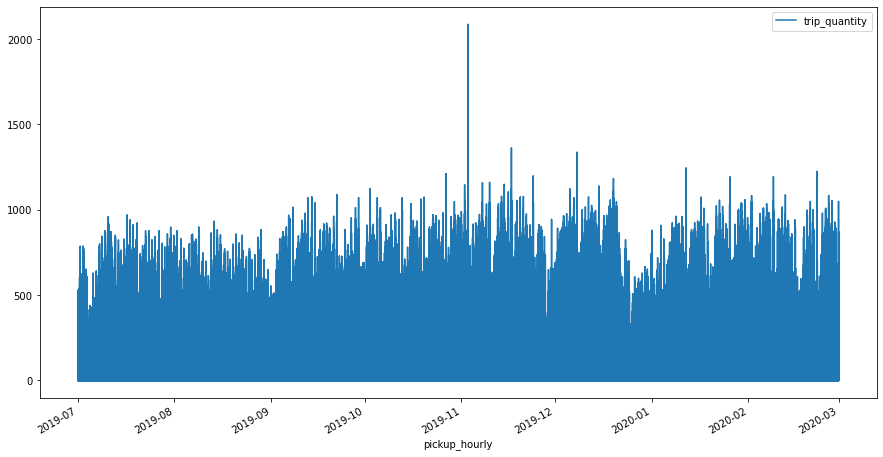

In [20]:
## PLOT OVERALL TIME SERIES - TO HELP INSPECT EXTREMES
df_raw.plot(x=timestamp, y=target_value, figsize=(15, 8))

In [21]:
# Replace extreme value with treated median last 6 months value or last 3 months if hourly data

if (replace_extremes_with_mean & (templist < MAX_EXTREMES)):
    df_clean = df_raw.copy()
    # calculate median
    replace_extreme = temp[target_value].median()
    print(f"replacing extreme value {df_clean.loc[(df_clean[target_value]>=EXTREME_VALUE), target_value].max()} with {replace_extreme}")
    # make the replacement
    df_clean.loc[((df_clean[item_id]==keys[item_id]) 
                       & (df_clean[location_id]==keys[location_id])
                       & (df_clean[timestamp]==keys[timestamp])), target_value] = replace_extreme
    print(f"new value is {df_clean.loc[((df_clean[item_id]==keys[item_id]) & (df_clean[location_id]==keys[location_id]) & (df_clean[timestamp]==keys[timestamp])), target_value].max()}")
    
    # Inspect extremes again on clean data
    EXTREME_VALUE = df_raw[target_value].quantile(0.999999)
    print(EXTREME_VALUE)

    templist = df_clean.loc[(df_clean[target_value]>=EXTREME_VALUE), :].shape[0]
    print(f"Number extremes: {templist}")

    if (templist < MAX_EXTREMES) & (templist > 0) :
        print(df_clean.loc[(df_clean[target_value]>=EXTREME_VALUE), :].set_index([item_id]))
        
    ## PLOT OVERALL TIME SERIES - TO SEE IF YOU DID THE RIGHT THING
    df_clean.plot(x=timestamp, y=target_value, figsize=(15, 8))
else:
    print("No extreme values found or do not replace any extremes.")
    df_clean = df_raw.copy()

No extreme values found or do not replace any extremes.


In [22]:
# save some memory
del df_raw

In [23]:
# throws error if we lost some values
assert original_shape[0] == df_clean.shape[0]

## Step 8. Optional - Round negative targets up to 0 <a class="anchor" id="round_negatives"></a>

In [24]:
# Check negative values
print(df_clean.loc[(df_clean[target_value] <0), :].shape)
df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

(0, 9)


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item


In [25]:
# CAREFUL!!  MAKE SURE ROUNDING NEGATIVES UP TO 0 MAKES SENSE FOR YOUR USE CASE

# If negative values found, round them up to 0
if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

    # Check y-value before cleaning
    print(df_clean[target_value].describe())

    # default negative values in demand to 0
    print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
    print()
    ts_cols = [target_value]

    for c in ts_cols:
        df_clean.loc[(df_clean[c] < 0.0), c] = 0.0

    # Check y-value after cleaning
    print(df_clean[target_value].describe())
else:
    print("No negative values found.")

No negative values found.


## Step 9. Optional - Convert negative targets to nan <a class="anchor" id="negatives_to_nan"></a>

In [26]:
# # Check negative values
# print(df_clean.loc[(df_clean[target_value] <0), :].shape)
# df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

In [27]:
# # # CAREFUL!!  MAKE SURE CHANGING NEGATIVES TO NAN NEGATIVES MAKES SENSE FOR YOUR USE CASE

# # If negative values found, round them up to 0
# if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

#     # Check y-value before cleaning
#     print(df_clean[target_value].describe())

#     # default negative values in demand to 0
#     print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
#     print()
#     ts_cols = [target_value]
    
#     print ()

#     for c in ts_cols:
#         df_clean.loc[(df_clean[c] < 0.0), c] = float('nan')
        
        

#     # Check y-value after cleaning
#     print(df_clean[target_value].describe())
# else:
#     print("No negative values found.")

In [28]:
# # throws error if we lost some values
# assert original_shape[0] == df_clean.shape[0]

## Step 10. Aggregate at your chosen frequency <a class="anchor" id="groupby_frequency"></a>

Below, we show an example of resampling at hourly frequency by forecast dimensions.  Modify the code to resample at other frequencies.

Decide which aggregation-level makes sense for your data, which is a balance between desired aggregation and what the data-collection frequency will support.

TODO:  Add parameter "Y", "M", "W", "D", "H", ... same as Forecast frequencies
Parameter:  forecast dimensions, assume timestamp, item_id
Adjust script so it can run automatically based on user input parameter

In [29]:
## CHECK TO SEE IF YOUR TIMESERIES DIMENSIONS ARE CORRECT

# checking if there are multiple entries per item_id per timestamp per location
df_aux = df_clean.copy().set_index([timestamp, item_id, location_id])

duplicates = df_aux.pivot_table(index=[item_id, location_id,timestamp], aggfunc='size')
duplicates = pd.DataFrame( duplicates, columns=["NumberPerTS"])

print (duplicates[duplicates["NumberPerTS"]>1].head())

Empty DataFrame
Columns: [NumberPerTS]
Index: []


In [30]:
# checking to see if your timeseries dimensions are correct
if duplicates[duplicates["NumberPerTS"]>1].shape[0] > 0:
    print("WARNING:  YOUR AGGREGATION ASSUMPTION THAT timestamp, item_id, location_id ARE UNIQUE IS NOT CORRECT.")
    print("Inspect df_aux where you see 'NumberPerTS' > 1")
else:
    print("Success!  timestamp, item_id, location_id is a unique grouping of your time series.")

Success!  timestamp, item_id, location_id is a unique grouping of your time series.


In case your assumed dimensions are not unique, code below is to explore adding a composite column.

In [31]:
# #  inspect what is happening on these repeated items
# try:
#     df_aux.reset_index(inplace = True)
# except Exception as e:
#     print (e)

# test_aux = df_aux[df_aux[item_id]=='1000655']
# test_aux.sort_values(by=[timestamp]).head()

In [32]:
# # Since warehouseId is not unique, create new fake composite column
# df_clean['location_id'] = df_clean['WarehouseId'] + 'R' + df_clean['RegionId']

In [33]:
# # map expected column names
# item_id = "SKUId"
# target_value = "Quantity"
# timestamp = "ReportingMonth"
# # location_id = "WarehouseId"
# location_id = "location_id"
# year = 'year'
# week = 'week'

In [34]:
# ## CHECK AGAIN TO SEE IF YOUR DATA AGGREGATION ASSUMPTION IS CORRECT

# # checking if there are multiple entries per item_id per timestamp per location
# df_aux = df_clean.copy().set_index([timestamp, item_id, location_id])

# duplicates = df_aux.pivot_table(index=[item_id, location_id,timestamp], aggfunc='size')
# duplicates = pd.DataFrame( duplicates, columns=["NumberPerTS"])

# # checking to see if your data aggregation is correct
# if duplicates[duplicates["NumberPerTS"]>1].shape[0] > 0:
#     print (duplicates[duplicates["NumberPerTS"]>1].head())
#     print("WARNING:  YOUR AGGREGATION ASSUMPTION THAT timestamp, item_id, location_id ARE UNIQUE IS NOT CORRECT.")
#     print("Inspect df_aux where you see 'NumberPerTS' > 1")
# else:
#     print("Success!  timestamp, item_id, location_id is a unique grouping of your time series.")

In [35]:
# # THIS CODE BLOCK IS AN EXAMPLE OF Monthly AGGREGATION

# ## Add month_year column for easier groupby sum
# df_clean['year'] = df_clean[timestamp].dt.year
# df_clean['year_month'] = df_clean[timestamp].dt.to_period("M").dt.to_timestamp()
# print(df_clean.sample(2))

# # check counts per year
# print()
# print("checking counts by year...")
# print(df_clean[year].value_counts(dropna=False).sort_index())

# # Aggregate target values at level you'd like
# # g_month = df_clean.groupby(['year_month', item_id]).sum()
# g_month = df_clean.groupby([timestamp, item_id, location_id]).sum()  #our timestamp already at year_month
# g_month = g_month[[target_value]]
# g_month.reset_index(inplace=True)
# print()
# print("sample aggregated dataframe:")
# print(g_month.head(2))
# print()


# # ERROR CHECK: DO YOU HAVE ENOUGH DATA POINTS PER TIME SERIES?
# # Deep Learning algorithms require at least 300 data points per time series, best if >1000 per time series.
# num_data_points = g_month.groupby([item_id, location_id]).count()[timestamp].max()
# if (num_data_points > 300):
#     print(f"Success, min number data points found!! Found {num_data_points} data points which is > 300.")
# else:
#     print(f"Error, too few data points.  Need at least 300, found {num_data_points}. ")
    
# # If you have too few data points, return to aggregation choice and choose smaller time granularity
# #   or, aggregate with fewer dimensions, e.g. product-level only instead of product-and-location.


# # INSPECT SPARSITY - Check 300-mark on your x-axis
# print("You want bulk of distribution to sit after 300-mark on x-axis.")
# print("If bulk of distribution is bunched closer to 0, choose smaller time granularity or aggregate item-level only.") 
# print("If all time series have same number of data points (distribution looks like 1 single bar), you might be able to use Amazon Forecast even though too few data points.")

# # num data points per item
# sparsity = g_month.copy()
# sparsity = sparsity.groupby([item_id, location_id]).count()
# sparsity[[target_value]].hist(bins=32);

(1507488, 4) (1507488, 9)


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
1022306,2019-12-13 11:00:00,197,40.69300047_-73.82904356,0
1134231,2019-12-31 14:00:00,117,40.59605583_-73.7760841,0
513738,2019-09-22 03:00:00,29,40.58219555_-73.96057985,0
951422,2019-12-01 23:00:00,69,40.83060768_-73.91536622,0
1073362,2019-12-21 17:00:00,248,40.8346772_-73.87101045,0


count   1507488.00000
mean         33.16301
std          94.59279
min           0.00000
25%           0.00000
50%           0.00000
75%           6.00000
max        2085.00000
Name: trip_quantity, dtype: float64


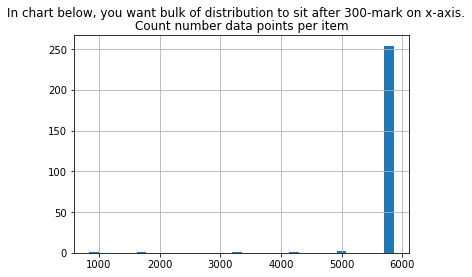

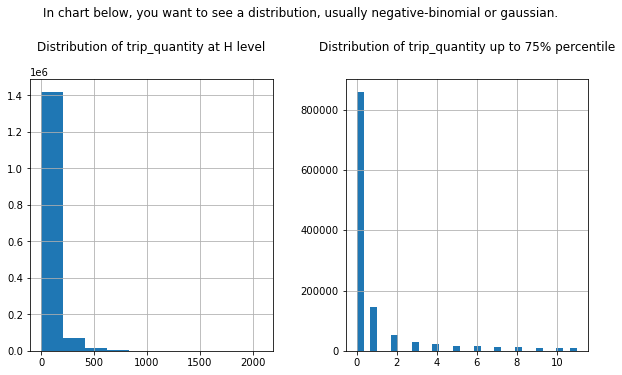

In [36]:
# THIS CODE BLOCK IS AN EXAMPLE OF Hourly AGGREGATION
# The sample data shipped with notebook is ideal - all time series have 5856 data points, 
# which is squarely in the Deep Learning desired data size.

# Add in time features
# Note: timestamp is already truncated to be hourly
agg_freq = "H"

# aggregate by hour
g_hour = df_clean.groupby([timestamp, item_id, location_id]).sum()
g_hour = g_hour[[target_value]]
g_hour.reset_index(inplace=True)
print(g_hour.shape, df_clean.shape)
display(g_hour.sample(5))

# In chart below, you want bulk of distribution to sit after 300-mark on x-axis.
# If bulk of distribution is bunched closer to 0, choose smaller time granularity or aggregate item-level only

# INSPECT SPARSITY
# num data points per item
sparsity = g_hour.copy()
sparsity = sparsity.groupby([item_id]).count()
sparsity[[target_value]].hist(bins=32);
plt.title("Count number data points per item");
plt.suptitle("In chart below, you want bulk of distribution to sit after 300-mark on x-axis.")


# INSPECT DISTRIBUTION OF TARGET_VALUES
dist = g_hour[target_value].describe()
print(dist)

# In chart below, you want to see the shape of a distribution (counts usually negative-binomial)
# You do not want to see a randomly uniform shape

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("In chart below, you want to see a distribution, usually negative-binomial or gaussian.", y=1.08)
# plot distribution of target_value itself
sparsity = g_hour.copy()
sparsity.hist(ax=axs[0])
axs[0].set_title(f"Distribution of {target_value} at {agg_freq} level", y=1.08);

# zoom-in plot distribution of target_value itself
sparsity = g_hour.copy()
sparsity = sparsity.loc[(sparsity[target_value]< 2*dist['75%']), :].copy()
sparsity.hist(bins=32, ax=axs[1])
axs[1].set_title(f"Distribution of {target_value} up to 75% percentile", y=1.08);

In [37]:
# inspect some items at tail
sparsity.head(2)
sparsity.loc[(sparsity[target_value] == dist['max']), :].head(2)

,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity


(2928, 2) (1507488, 4)


,pickup_hourly,trip_quantity
1278,2019-10-15 12:00:00,22548
836,2019-09-08 16:00:00,21010


count    2928.00000
mean    17074.05806
std      8556.73841
min      1144.00000
25%     10359.50000
50%     19453.00000
75%     23656.00000
max     36751.00000
Name: trip_quantity, dtype: float64


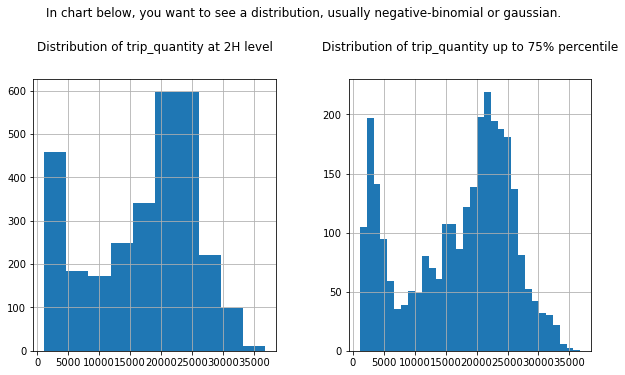

In [38]:
## TRY ANOTHER AGGREGATION LEVEL AND COMPARE TARGET_VALUE DISTRIBUTION SHAPES
agg_freq = "2H"

# aggregate by 2-hour
g_2hour = df_clean[[timestamp, item_id, location_id, target_value]].copy()
g_2hour.set_index(timestamp, inplace=True)
g_2hour = g_2hour.groupby(pd.Grouper(freq=agg_freq)).sum()
g_2hour.reset_index(inplace=True)
print(g_2hour.shape, g_hour.shape)
display(g_2hour.sample(2))

# INSPECT DISTRIBUTION OF TARGET_VALUES
dist = g_2hour[target_value].describe()
print(dist)

# In chart below, you want to see the shape of a distribution (counts usually negative-binomial)
# You do not want to see a randomly uniform shape

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("In chart below, you want to see a distribution, usually negative-binomial or gaussian.", y=1.08)
# plot distribution of target_value itself
sparsity = g_2hour.copy()
sparsity.hist(ax=axs[0])
axs[0].set_title(f"Distribution of {target_value} at {agg_freq} level", y=1.08);

# zoom-in plot distribution of target_value itself
sparsity = g_2hour.copy()
sparsity = sparsity.loc[(sparsity[target_value]< 2*dist['75%']), :].copy()
sparsity.hist(bins=32, ax=axs[1])
axs[1].set_title(f"Distribution of {target_value} up to 75% percentile", y=1.08);

(1464, 2) (1507488, 4)


,pickup_hourly,trip_quantity
528,2019-09-27 00:00:00,15891
214,2019-08-05 16:00:00,45791


count    1464.00000
mean    34148.11612
std     16127.75335
min      4169.00000
25%     18517.00000
50%     38847.50000
75%     47115.50000
max     64948.00000
Name: trip_quantity, dtype: float64


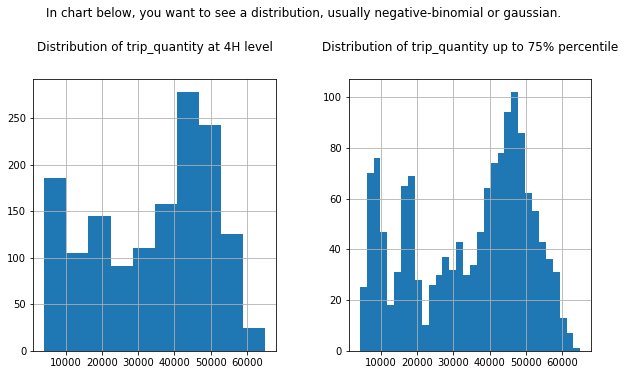

In [39]:
## TRY ANOTHER AGGREGATION LEVEL AND COMPARE TARGET_VALUE DISTRIBUTION SHAPES
agg_freq = "4H"

# aggregate by 2-hour
g_4hour = df_clean[[timestamp, item_id, location_id, target_value]].copy()
g_4hour.set_index(timestamp, inplace=True)
g_4hour = g_4hour.groupby(pd.Grouper(freq=agg_freq)).sum()
g_4hour.reset_index(inplace=True)
print(g_4hour.shape, g_hour.shape)
display(g_4hour.sample(2))

# INSPECT DISTRIBUTION OF TARGET_VALUES
dist = g_4hour[target_value].describe()
print(dist)

# In chart below, you want to see the shape of a distribution (counts usually negative-binomial)
# You do not want to see a randomly uniform shape

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("In chart below, you want to see a distribution, usually negative-binomial or gaussian.", y=1.08)
# plot distribution of target_value itself
sparsity = g_4hour.copy()
sparsity.hist(ax=axs[0])
axs[0].set_title(f"Distribution of {target_value} at {agg_freq} level", y=1.08);

# zoom-in plot distribution of target_value itself
sparsity = g_4hour.copy()
sparsity = sparsity.loc[(sparsity[target_value]< 2*dist['75%']), :].copy()
sparsity.hist(bins=32, ax=axs[1])
axs[1].set_title(f"Distribution of {target_value} up to 75% percentile", y=1.08);

<br>

<b> Select the aggregation-level to keep, based on results above.</b>

In [40]:
## USE THE GROUPING YOU SELECTED ABOVE

df = g_hour.copy()
# save memory
del g_hour

print(df.shape, df_clean.shape)
df.head(2)

(1507488, 4) (1507488, 9)


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
0,2019-07-01,1,40.68951565_-74.17678575,0
1,2019-07-01,10,40.6781247_-73.79166546,1


In [41]:
# Change timestamp column mapping if necessary
# timestamp = "year_month"

## Step 11. Typical retail scenarios: Find top-moving items <a class="anchor" id="top_moving_items"></a>

Next, we want to drill down and visualize some individual item time series.  Typically customers have "catalog-type" data, where only the top 20% of their items are top-movers; the rest of the 80% of items are not top-movers.  For visualization, we want to select automatically some of the top-moving items.

In [42]:
if len(location_id) >0:
    use_location = True
else:
    use_location = False
    
use_location = False

In [43]:
## FIND TOP-MOVING ITEMS

if use_location:
    print("using location_id")
    df_velocity, df_ts_velocity = get_top_moving_items(df, timestamp, target_value, item_id, location_id)
else:
    print("using only item_id")
    df_velocity, df_ts_velocity = get_top_moving_items(df, timestamp, target_value, item_id, None)

# Display breakdown: how many top-moving items
if use_location:
    num_top = df_ts_velocity.loc[(df_ts_velocity.top_moving==True), :].groupby([item_id, location_id]).first().shape[0]
    num_slow = df_ts_velocity.loc[(df_ts_velocity.top_moving==False), :].groupby([item_id, location_id]).first().shape[0]
    num_time_series = df.groupby([item_id, location_id]).first().shape[0]
    print(f"number of top moving time series: {num_top}, ratio:{np.round(num_top/num_time_series,2)}")
    print(f"number of slow moving time series: {num_slow}, ratio: {np.round(num_slow/num_time_series,2)}")
    print()
    top_moving_ts = df_ts_velocity.loc[(df_ts_velocity.top_moving==True), :]
    slow_moving_ts = df_ts_velocity.loc[(df_ts_velocity.top_moving==False), :]
    print("Top-moving time series")
    print(top_moving_ts.sort_values('velocity', ascending=False).head(3))
    print()
    print("Slow-moving time series")
    print(slow_moving_ts.sort_values('velocity', ascending=False).head(2))
else:
    num_top = df_velocity.loc[(df_velocity.top_moving==True), item_id].nunique()
    num_slow = df_velocity.loc[(df_velocity.top_moving==False), item_id].nunique()
    num_time_series = df[item_id].nunique()
    print(f"number of top moving items: {num_top}, ratio:{num_top/num_time_series}")
    print(f"number of slow moving items: {num_slow}, ratio: {num_slow/num_time_series}")
    print("Top-moving items")
    top_moving_items = df_velocity.loc[(df_velocity.top_moving==True), :].sort_values('velocity', ascending=False).copy()
    print(top_moving_items.head(3))
    print()
    print("Slow-moving items")
    slow_moving_items = df_velocity.loc[(df_velocity.top_moving==False), :].sort_values('velocity', ascending=False).copy()
    print(slow_moving_items.head(2))

using only item_id
No location found
number of top moving items: 47, ratio:0.18076923076923077
number of slow moving items: 213, ratio: 0.8192307692307692
Top-moving items
    pulocationid  time_span  trip_quantity    velocity  top_moving
150          237   24.00000        2234548 93106.16667        True
66           161   24.00000        2121595 88399.79167        True
149          236   24.00000        2005360 83556.66667        True

Slow-moving items
    pulocationid  time_span  trip_quantity   velocity  top_moving
247           88   24.00000         185184 7716.00000       False
196           41   24.00000         183922 7663.41667       False


In [44]:
# Instead of completely random items, select top-moving items
if use_location:
    random_items = top_moving_ts[[item_id, location_id]].sample(5)
    random_locations = list(random_items[location_id])
    random_items = list(random_items[item_id])
else:
    random_items = top_moving_items[item_id].sample(5)
    random_items = random_items.reset_index()
    random_items = random_items[item_id]
    
print(random_items)
if use_location:
    print(random_locations)

0    170
1     79
2    261
3    100
4    263
Name: pulocationid, dtype: object


In [45]:
random_items = list(random_items) + ['79', '135']
random_items

['170', '79', '261', '100', '263', '79', '135']

## Step12. Visualize time series <a class="anchor" id="visualize"></a>

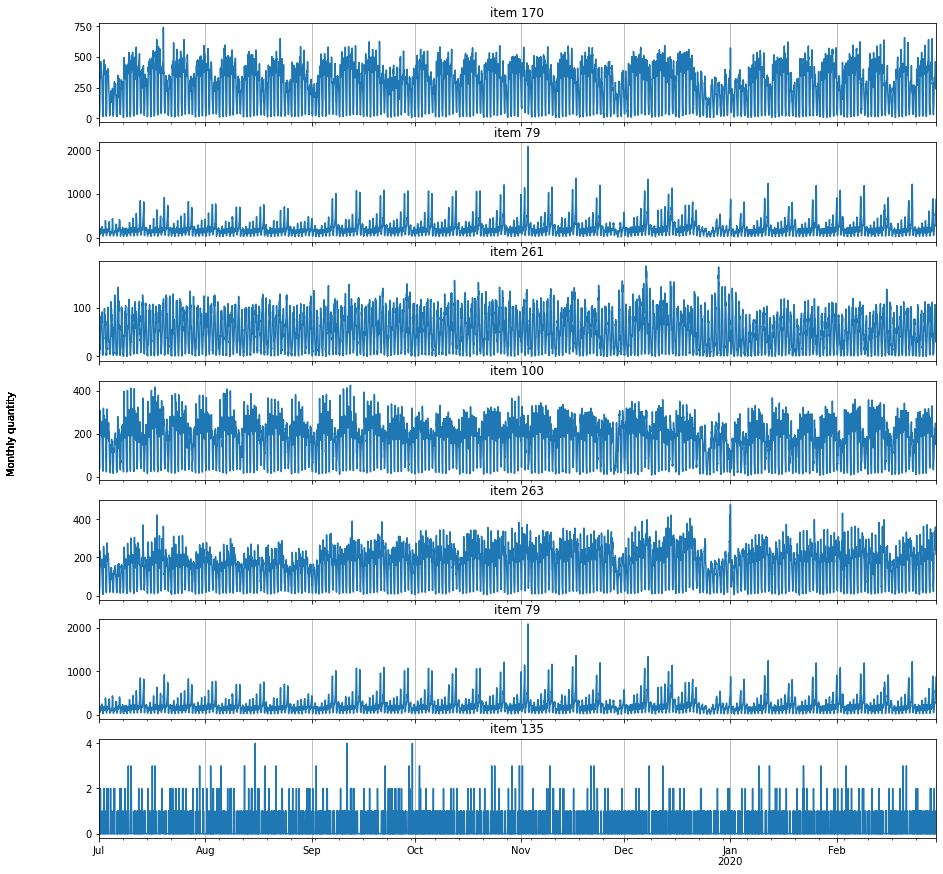

In [46]:
# PREPARE PLOTS OF RANDOM TOP-MOVING ITEMS AND LOCATIONS
# We chose top-moving items to avoid visualizing time series that might be empty or very sparse.

if use_location:
    df_plot = df.loc[(df[item_id].isin(random_items)), [item_id, timestamp, target_value, location_id]].copy()
    df_plot = df.loc[(df[location_id].isin(random_locations)), [item_id, timestamp, target_value, location_id]].copy()
else:
    df_plot = df.loc[(df[item_id].isin(random_items)), [item_id, timestamp, target_value]].copy()  

df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)

# make plots
make_plots(df_plot, use_location, random_items, sample_locations=[])

## Step 13. Classify Time Series <a class="anchor" id="Classify"></a>
Using definitions given here:  https://frepple.com/blog/demand-classification/ and here: https://support.demandcaster.com/hc/en-us/articles/360043259931-Forecast-Structure<br>
Original article:  https://robjhyndman.com/papers/idcat <br>

Idea:  Based on demand patterns, time series can be classified into one of 4 classes:  Regular, Intermittent, Erratic, or Lumpy.  If you have more than 1 class of time series in your data, this might suggest more than 1 model for your time series predictions.  

Rules:
<ol>
    <li><b>Regular</b> demand (ADI < 1.32 and CV² < 0.49). Regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level. Suggested algorithm: <b>Traditional statistical such as Exponential Smoothing, Prophet, or ARIMA.</b></li>
    <li><b>Intermittent demand</b> (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher. Suggested algorithm: <b>Croston smoothing or some newer research approach coupled with adjusted error metric over longer time period.</b></li>
    <li><b>Erratic</b> demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky. Suggested algorithm: <b>Deep Learning</b></li>
<li><b>Lumpy</b> demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable. Suggested algorithm: <b>bootstrap</b></li>
    </ol>

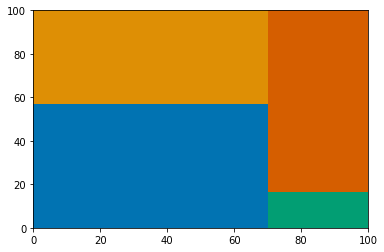

In [47]:
!pip install squarify
import squarify

# SCRATCH - choose 4 colors
colors = colorblind6[0:4]
sizes = [40, 30, 5, 25]
squarify.plot(sizes, color=colors)
plt.show();

Trick:  create dataframe without any missing values using cross-join, faster than resample technique.

In [48]:
# idx = pd.date_range(start=new_start_date, end=end_date, freq='D')
# idx = pd.date_range(start=start_time, end=end_time, freq='MS')
idx = pd.date_range(start=start_time, end=end_time, freq='H')
all_times = pd.DataFrame(index=idx)
print (f"Number of data points: {len(all_times.index)}")
print (f"Start date = {all_times.index.min()}")
print (f"End date = {all_times.index.max()}")

# Create timestamp column
all_times.reset_index(inplace=True)
all_times.columns = [timestamp]

# Create other time-related columns if you need them in RTS
# all_times['month'] = all_times[timestamp].dt.month.astype(str)
# all_times['year'] = all_times[timestamp].dt.year.astype(str)
# all_times['quarter'] = all_times[timestamp].dt.quarter.astype(str)
# all_times['year_month'] = all_times['year'] + '_' + all_times[timestamp].dt.month
all_times['day_of_week'] = all_times[timestamp].dt.day_name().astype(str)
all_times['hour_of_day'] = all_times[timestamp].dt.hour.astype(str)
all_times['day_hour_name'] = all_times['day_of_week'] + "_" + all_times['hour_of_day']
all_times['weekend_flag'] = all_times[timestamp].dt.dayofweek
all_times['weekend_flag'] = (all_times['weekend_flag'] >= 5).astype(int)
all_times['is_sun_mon'] = 0
all_times.loc[((all_times.day_of_week=="Sunday") | (all_times.day_of_week=="Monday")), 'is_sun_mon'] = 1

print(all_times.dtypes)
print(all_times.isna().sum())
all_times.sample(5)

Number of data points: 5856
Start date = 2019-07-01 00:00:00
End date = 2020-02-29 23:00:00
pickup_hourly    datetime64[ns]
day_of_week              object
hour_of_day              object
day_hour_name            object
weekend_flag              int64
is_sun_mon                int64
dtype: object
pickup_hourly    0
day_of_week      0
hour_of_day      0
day_hour_name    0
weekend_flag     0
is_sun_mon       0
dtype: int64


,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon
3670,2019-11-30 22:00:00,Saturday,22,Saturday_22,1,0
1274,2019-08-23 02:00:00,Friday,2,Friday_2,0,0
649,2019-07-28 01:00:00,Sunday,1,Sunday_1,1,1
4785,2020-01-16 09:00:00,Thursday,9,Thursday_9,0,0
2355,2019-10-07 03:00:00,Monday,3,Monday_3,0,1


In [49]:
use_location

False

In [50]:
# create master template of all possible locations and items
items = df.groupby([item_id, location_id]).min()

# # subset just top items
# items = tts_top.groupby([item_id, location_id]).min()

# drop timestamp
items.reset_index(inplace=True)
items.drop([timestamp, target_value], axis=1, inplace=True)
# items.head(2)

if use_location:
    locations = pd.DataFrame(list(tts[location_id].unique()))
    locations.columns = [location_id]
    # locations.head()
    locations['key'] = 1
    items['key'] = 1
    # Do the cross-join
    master_records = locations.merge(items, on ='key').drop("key", 1) 
    print(master_records.shape, items.shape, locations.shape)
    num_locs = len(master_records[location_id].value_counts())
    print(f"num locations: {num_locs}")
else:
    master_records = items.copy()
    print(master_records.shape, items.shape)

# check you did the right thing
num_items = len(master_records[item_id].value_counts())
master_records.tail()

(260, 2) (260, 2)


,pulocationid,pickup_geolocation
255,95,40.72346527_-73.84821994
256,96,40.69576099_-73.87601222
257,97,40.69061566_-73.97557658
258,98,40.73384122_-73.77955023
259,99,40.57961795_-74.18770274


In [51]:
# cross-join to create master template of all possible locations and items and times
all_times['key'] = 1
master_records['key'] = 1

# Do the cross-join
full_history = all_times.merge(master_records, on ='key').drop("key", 1) 

# make sure you don't have any nulls
print(full_history.shape)
print("checking nulls...")
print(full_history.isna().sum())
full_history.tail()

(1522560, 8)
checking nulls...
pickup_hourly         0
day_of_week           0
hour_of_day           0
day_hour_name         0
weekend_flag          0
is_sun_mon            0
pulocationid          0
pickup_geolocation    0
dtype: int64


,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,pulocationid,pickup_geolocation
1522555,2020-02-29 23:00:00,Saturday,23,Saturday_23,1,0,95,40.72346527_-73.84821994
1522556,2020-02-29 23:00:00,Saturday,23,Saturday_23,1,0,96,40.69576099_-73.87601222
1522557,2020-02-29 23:00:00,Saturday,23,Saturday_23,1,0,97,40.69061566_-73.97557658
1522558,2020-02-29 23:00:00,Saturday,23,Saturday_23,1,0,98,40.73384122_-73.77955023
1522559,2020-02-29 23:00:00,Saturday,23,Saturday_23,1,0,99,40.57961795_-74.18770274


In [52]:
# add in original target_value

temp_target = df[[timestamp, item_id, target_value]].copy()

# merge in target_value
temp2 = full_history.copy()
temp = temp2.merge(temp_target, how="left", on=[timestamp, item_id])
print(temp.shape, full_history.shape)

# check nulls
print(temp.isna().sum())
temp.sample(5)

(1522560, 9) (1522560, 8)
pickup_hourly             0
day_of_week               0
hour_of_day               0
day_hour_name             0
weekend_flag              0
is_sun_mon                0
pulocationid              0
pickup_geolocation        0
trip_quantity         15072
dtype: int64


,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,pulocationid,pickup_geolocation,trip_quantity
1459352,2020-02-19 20:00:00,Wednesday,20,Wednesday_20,0,0,74,40.80556557_-73.9383105,26.00000
533726,2019-09-24 12:00:00,Tuesday,12,Tuesday_12,0,0,50,40.76669237_-73.9938994,99.00000
44250,2019-07-08 02:00:00,Monday,2,Monday_2,0,1,147,40.81919853_-73.89819293,0.00000
1019699,2019-12-11 09:00:00,Wednesday,9,Wednesday_9,0,0,80,40.71446957_-73.94232931,0.00000
727377,2019-10-25 13:00:00,Friday,13,Friday_13,0,0,243,40.85867029_-73.93282432,0.00000


In [53]:
# Careful!!
# Really replace full_history with merged values
full_history = temp.copy()
full_history.head(2)

,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,pulocationid,pickup_geolocation,trip_quantity
0,2019-07-01,Monday,0,Monday_0,0,1,1,40.68951565_-74.17678575,0.00000
1,2019-07-01,Monday,0,Monday_0,0,1,10,40.6781247_-73.79166546,1.00000


In [54]:
# For each time series, calculate ADI
temp = full_history.copy()
temp = temp.groupby([item_id]).apply(lambda x: calc_ADI(x, timestamp, item_id, target_value))
temp.reset_index(drop=True, inplace=True)
display(temp.sample(3))

# Capture each time series class counts
ts_counts = temp.groupby(item_id)[['ts_type']].first()
ts_counts.reset_index(inplace=True)
ts_counts = ts_counts.ts_type.value_counts(dropna=False)
print("TIME SERIES CLASSES: ")
display(ts_counts)
print(f"NUMBER OF DISTINCT CLASSES OF TIME SERIES = {temp.ts_type.nunique()}")

,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,pulocationid,pickup_geolocation,trip_quantity,ADI,CV,ts_type
1018466,2020-02-10 02:00:00,Monday,2,Monday_2,0,1,258,40.69012637_-73.85663905,0.00000,1.00000,0.25064,regular
674746,2019-08-24 10:00:00,Saturday,10,Saturday_10,1,0,205,40.69221897_-73.76261566,1.00000,1.00000,0.41646,regular
1178020,2019-08-10 04:00:00,Saturday,4,Saturday_4,1,0,46,40.8474999_-73.78648631,0.00000,1.00000,0.00000,regular


TIME SERIES CLASSES: 


regular         136
erratic         121
intermittent      2
lumpy             1
Name: ts_type, dtype: int64

NUMBER OF DISTINCT CLASSES OF TIME SERIES = 4


In [55]:
print(temp.shape, full_history.shape)

(1522560, 12) (1522560, 9)


In [56]:
# Careful!!
# Really replace full_history with class values
full_history = temp.copy()
del temp
full_history.head(2)

,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,pulocationid,pickup_geolocation,trip_quantity,ADI,CV,ts_type
0,2019-07-01 00:00:00,Monday,0,Monday_0,0,1,1,40.68951565_-74.17678575,0.00000,1.00000,0.28580,regular
1,2019-07-01 01:00:00,Monday,1,Monday_1,0,1,1,40.68951565_-74.17678575,0.00000,1.00000,0.28580,regular


,ts_type,ts_type_count,ts_type_percent
0,regular,136,52.31000
1,erratic,121,46.54000
2,intermittent,2,0.77000
3,lumpy,1,0.38000


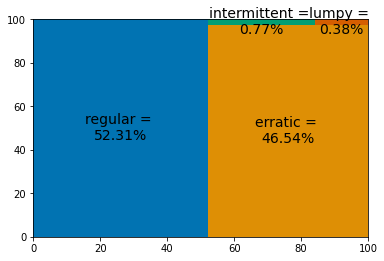

In [57]:
# Plot the time series classes using tree map
ts_classes = pd.DataFrame(ts_counts)
ts_classes.reset_index(inplace=True, drop=False)
ts_classes.columns = ['ts_type', 'ts_type_count']
sum_total = ts_classes['ts_type_count'].sum()
ts_classes['ts_type_percent'] = 100.0 * ts_classes['ts_type_count'] / sum_total
ts_classes['ts_type_percent'] = ts_classes['ts_type_percent'].round(2)
display(ts_classes)

# tree map
lbl = [f"{c[0]} = \n{c[1]}%" for c in zip(ts_classes.ts_type, ts_classes.ts_type_percent)]
squarify.plot(
    label=lbl
    , sizes=list(ts_classes.ts_type_count)
    , color=colors
    , text_kwargs={'fontsize':14});

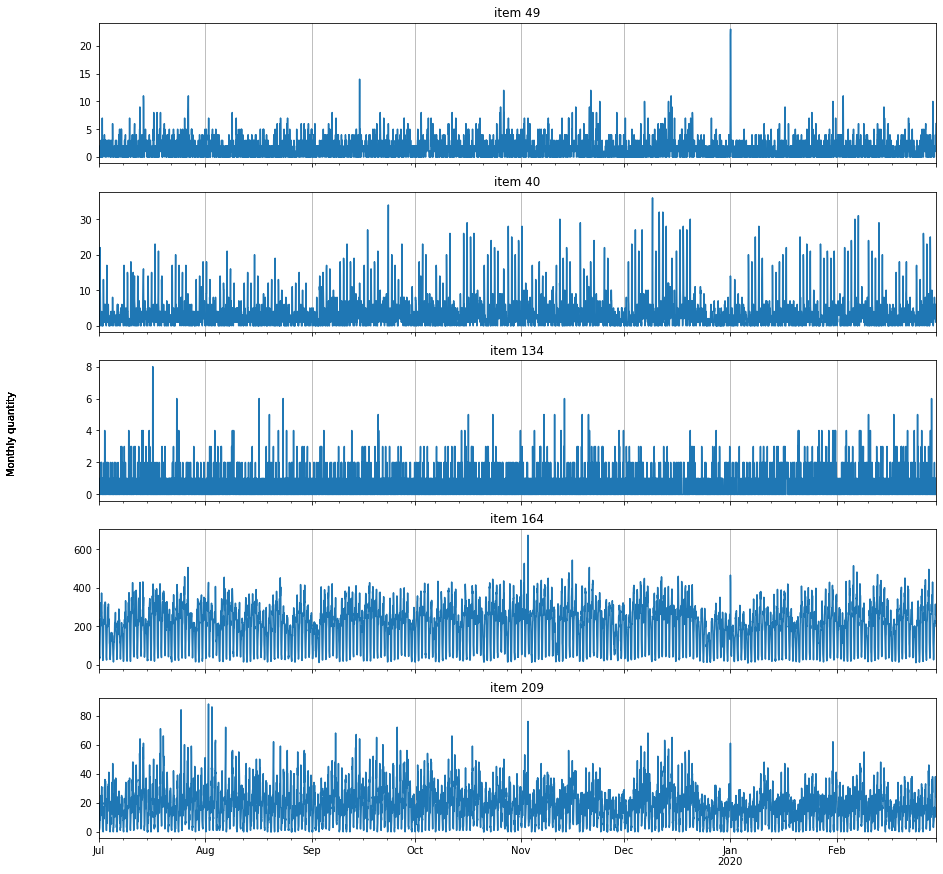

In [58]:
# visualize some erratic time series
erratic_sample = full_history.loc[(full_history.ts_type=="erratic"), [timestamp, item_id, target_value]]
erratic_sample.set_index(timestamp, inplace=True)
erratic_sample.head(2)

# random sample 5
erratic_items = erratic_sample[item_id].sample(5)
erratic_items = erratic_items.reset_index()
erratic_items = erratic_items[item_id].unique()
erratic_items

# make plots
make_plots(erratic_sample, use_location, erratic_items, sample_locations=[])


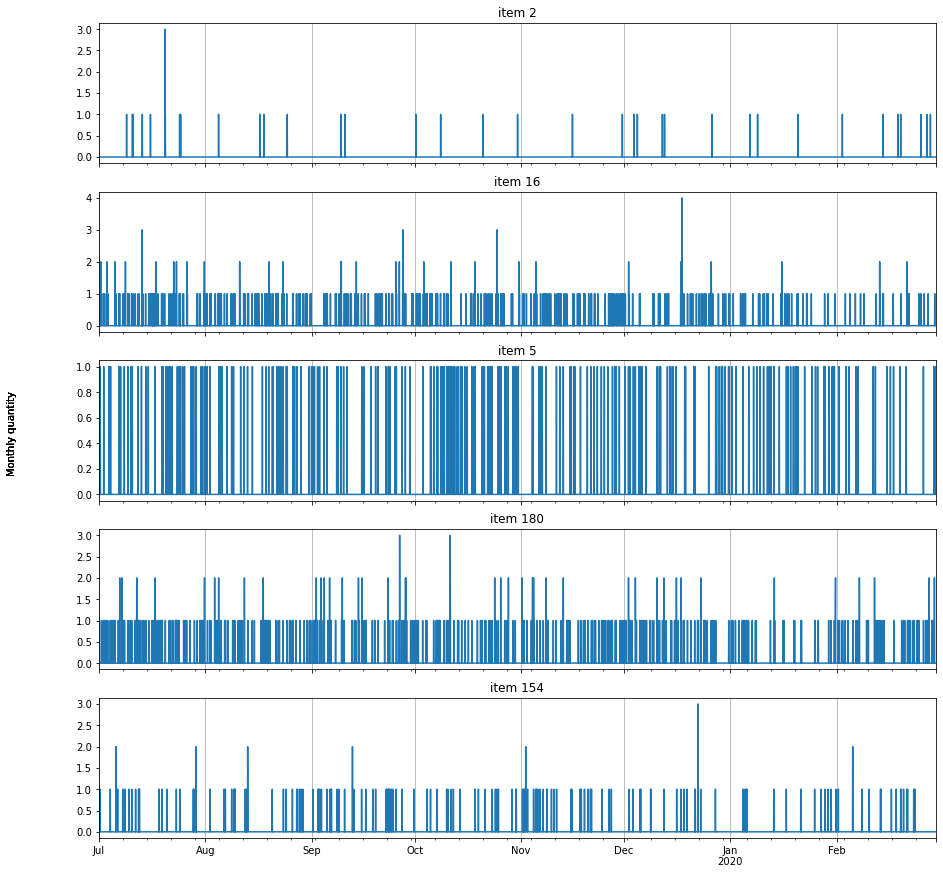

In [59]:
# visualize some regular time series
regular_sample = full_history.loc[(full_history.ts_type=="regular"), [timestamp, item_id, target_value]]
regular_sample.set_index(timestamp, inplace=True)
regular_sample.head(2)

# random sample 5
regular_items = regular_sample[item_id].sample(5)
regular_items = regular_items.reset_index()
regular_items = regular_items[item_id].unique()
regular_items

# make plots
make_plots(regular_sample, use_location, regular_items, sample_locations=[])


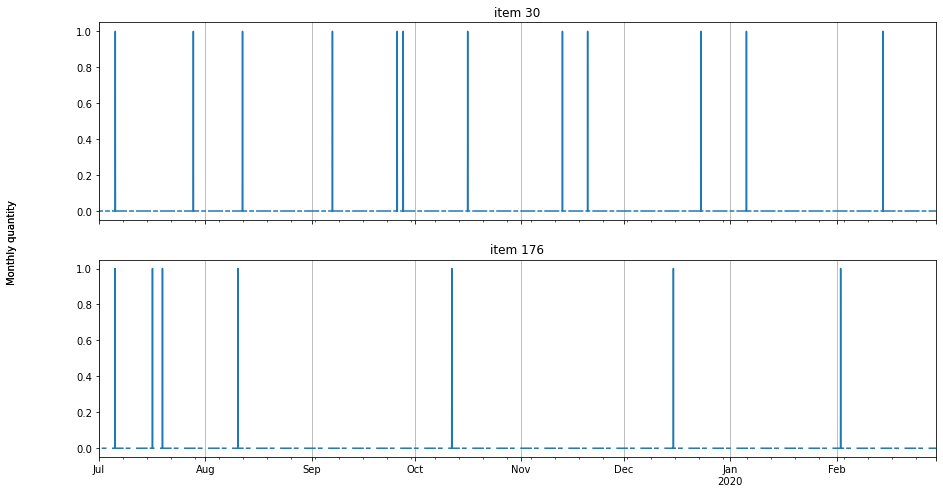

In [60]:
# visualize some intermittent time series
intermittent_sample = full_history.loc[(full_history.ts_type=="intermittent"), [timestamp, item_id, target_value]]
intermittent_sample.set_index(timestamp, inplace=True)
intermittent_sample.head(2)

# random sample 5
intermittent_items = intermittent_sample[item_id].sample(5)
intermittent_items = intermittent_items.reset_index()
intermittent_items = intermittent_items[item_id].unique()
intermittent_items

# make plots
make_plots(intermittent_sample, use_location, intermittent_items, sample_locations=[])

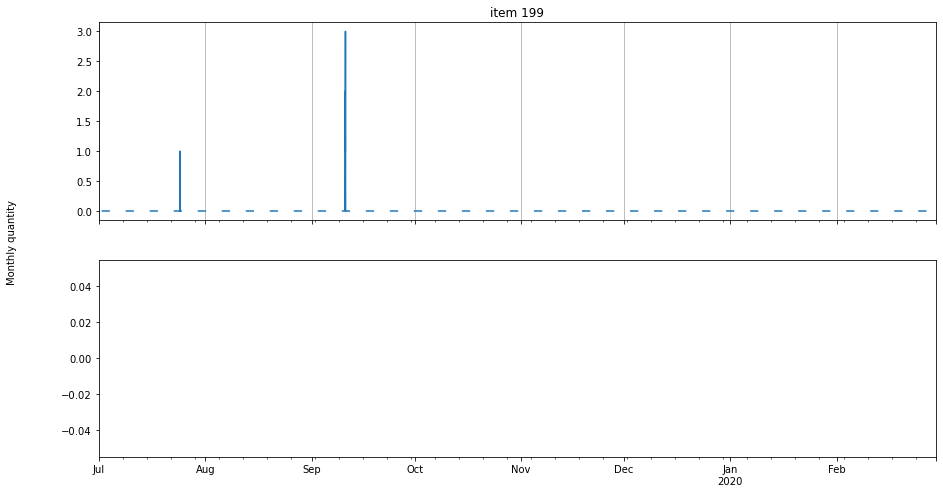

In [61]:
# visualize some lumpy time series
lumpy_sample = full_history.loc[(full_history.ts_type=="lumpy"), [timestamp, item_id, target_value]]
lumpy_sample.set_index(timestamp, inplace=True)
lumpy_sample.head(2)

# random sample 5
lumpy_items = lumpy_sample[item_id].sample(5)
lumpy_items = lumpy_items.reset_index()
lumpy_items = lumpy_items[item_id].unique()
lumpy_items

# make plots
make_plots(lumpy_sample, use_location, lumpy_items, sample_locations=[])

It looks like only "erratic" time series are worth predicting.  All the rest look either suspiciously fake or too few data points.

## Step 14. Split train/test data  <a class="anchor" id="split_train_test"></a> 

In forecasting, "train" data is until a last-train date, sometimes called the forecast snapshot date.  
<ul>
    <li>Train data includes all data up to your last-train date. </li>
    <li>Test data includes dates after your last-train date through end of desired forecast horizon.</li>
    <li>Validation data might exist for part or maybe all of the desired forecast horizon. </li>
    <li>TTS timestamps should start and end with Train data. </li>
    <li>RTS timestamps should start with Train data and extend out past end of TTS to end of the desired forecast horizon.</li>
    </ul>
    
For model generalization, all processing from here on out will only be done on train data.


TODO:  Adjust this section so you can 1) create RTS with known data, or 2) create RTS with unknown future data.

In [62]:
# Forecast Horizon is number of time steps out in the future you want to predict
# Time steps are defined in the time frequency you specified in Step 5 Aggregate

# Example if aggregation was hourly, then forecast length=168 means forecast horizon of 7 days or 7*24=168 hours
print(f"Forecast horizon = {FORECAST_LENGTH}") # = 12
print(f"Forecast unit of frequency = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}") # = 30
print(f"Forecast start date = {SNAPSHOT_DATE}")

Forecast horizon = 168
Forecast unit of frequency = hours
Forecast start date = 2020-02-23 00:00:00


In [63]:
# Create train data as all except last FORECAST_HORIZON length
start_time = df[timestamp].min()
end_time = snapshot_end
start_time_test = SNAPSHOT_DATE

print(f"start_time = {start_time}")
print(f"end_time_train = {end_time_train}")
print(f"start_time_test = {start_time_test}")
print(f"end_time = {snapshot_end}")

start_time = 2019-07-01 00:00:00
end_time_train = 2020-02-22 23:00:00
start_time_test = 2020-02-23 00:00:00
end_time = 2020-02-29 23:00:00


In [64]:
create_future_RTS_with_unknown_data

False

In [65]:
if create_future_RTS_with_unknown_data:
    # Create train data as all data => this means RTS will extend into unknown future
    print("using all known data for training")
    train_df = df_clean.copy()
else:
    # Create train subset with hold-out of length FORECAST_LENGTH
    print("using hold-out with train data")
    train_df = df_clean.copy()
    train_df = train_df.loc[(train_df[timestamp] <= end_time_train), :]

# check you did the right thing
print(f"start_time = {start_time}")
print(f"end_time: {end_time}")
print()
print(f"start_time_train = {train_df[timestamp].min()}")
print(f"end_time_train = {train_df[timestamp].max()}")
train_df.head()

using hold-out with train data
start_time = 2019-07-01 00:00:00
end_time: 2020-02-29 23:00:00

start_time_train = 2019-07-01 00:00:00
end_time_train = 2020-02-22 23:00:00


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,1,2019-07-02 09:00:00,Tuesday,Tuesday_9,0,1.00000,40.68951565_-74.17678575,EWR,Cat_1
1,1,2019-07-03 01:00:00,Wednesday,Wednesday_1,0,1.05769,40.68951565_-74.17678575,EWR,Cat_1
2,1,2019-07-05 06:00:00,Friday,Friday_6,0,1.13208,40.68951565_-74.17678575,EWR,Cat_1
3,1,2019-07-06 08:00:00,Saturday,Saturday_8,0,1.08333,40.68951565_-74.17678575,EWR,Cat_1
4,1,2019-07-26 17:00:00,Friday,Friday_17,0,1.13208,40.68951565_-74.17678575,EWR,Cat_1


In [66]:
# ERROR CHECK: DO YOU HAVE ENOUGH HISTORICAL DATA POINTS TO SUPPORT DESIRED FORECAST HORIZON?

# calculate number data points in train data
num_data_points = train_df.groupby([item_id]).nunique()[timestamp].mean()
print(f"1/3 training data points: {np.round(num_data_points/3,0)}")

# Amazon Forecast length of forecasts can be 500 data points and 1/3 target time series dataset length
if ((FORECAST_LENGTH < 500) & (FORECAST_LENGTH <= np.round(num_data_points/3,0))):
    print(f"Success, forecast horizon {FORECAST_LENGTH} is shorter than 500 data points and 1/3 train data")
else:
    print(f"Error, forecast horizon {FORECAST_LENGTH} is too long.  Need fewer than 500 data points and 1/3 train data. ")
    
# If you have too few data points, return to step above and choose smaller time granularity

1/3 training data points: 1877.0
Success, forecast horizon 168 is shorter than 500 data points and 1/3 train data


## Step 15. Prepare and Save Target Time Series (TTS) <a class="anchor" id="TTS"></a>

In [67]:
create_future_RTS_with_unknown_data

False

In [68]:
## Assemble TTS required columns

tts = train_df[[timestamp, item_id, location_id, target_value]].copy()
tts = tts.groupby([timestamp, item_id, location_id]).sum()
tts.reset_index(inplace=True)

# check it
print(tts.shape)
print(f"start date = {tts[timestamp].min()}")
print(f"end date = {tts[timestamp].max()}")
print(tts.dtypes)
tts.sample(5)

(1464240, 4)
start date = 2019-07-01 00:00:00
end date = 2020-02-22 23:00:00
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
216666,2019-08-05 01:00:00,257,40.6536645_-73.97723931,0
687834,2019-10-20 07:00:00,94,40.85826076_-73.90059101,0
258495,2019-08-11 20:00:00,137,40.74035924_-73.97711937,96
349921,2019-08-26 15:00:00,177,40.67709861_-73.91110579,0
137340,2019-07-23 05:00:00,231,40.71869564_-74.00671162,35


In [69]:
# check format of geolocation column
# tts.pickup_geolocation.value_counts(normalize=True, dropna=False)

<b>Optional - convert target_value to integer if this is the last step for TTS. </b>

Note: Currently in Amazon Forecast, if you declare target_value is integer in the schema, but you have any decimals in your numbers, you will get an error.

Make sure you really see integers in the code below, if you want integers!

In [70]:
target_to_integer

False

In [71]:
# # Use the new pandas Integer type
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html
# # TODO: turn this into a function

# if target_to_integer:
#     try:
#         tts[target_value] = tts[target_value].astype(int)
#         print("Success! Converted to numpy integer")
#     except Exception as e:
#         print (e)
#         print("Trying pandas nullable Integer type instead of numpy integer type...")
#         try:
#             tts[target_value] = tts[target_value].fillna(0).astype('Int64', errors='ignore')
#             print("Success! converted to pandas integer")
#         except Exception as e:
#             print (e)
# elif tts[target_value].dtype == 'object':
#     # convert to float
#     tts[target_value] = tts[target_value].astype(np.float32)
# elif tts[target_value].dtype != 'object':
#     # do nothing
#     print("target_value is already a float")
    
# print(tts.dtypes)
# tts.sample(5)

In [72]:
# # Save tts to S3
# local_file = "tts.csv"
# # Save merged file locally
# tts.to_csv(local_file, header=True, index=False)

# # Save file to S3
# key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
# boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

## Step 16. Remove time series with no target values at all<a class="anchor" id="TTS-remove-all0"></a>

In case there are time series which are only 0's, may as well remove them, since their forecast should be all 0's too.  Another reason to remove these time series is they could bias the overall forecast toward 0, when that's not what you want.

In [73]:
print(tts.shape)
tts.dtypes

(1464240, 4)


pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object

In [74]:
# check if sum of all sales is 0
g = tts.groupby([item_id, location_id]).sum()
skus_with_no_sales_in_warehouse = g[g[target_value] == 0].copy()

skus_with_no_sales_in_warehouse.reset_index(inplace=True)
skus_with_no_sales_in_warehouse.drop(target_value, inplace=True, axis=1)
# print(skus_with_too_few_sales.shape)
# display (skus_with_no_sales_in_warehouse.head(2))

if skus_with_no_sales_in_warehouse.shape[0] > 0:
        
    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_no_sales_in_warehouse, how='left', on=[item_id, location_id], indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with only 0's.")


No time series found with only 0's.


In [75]:
# really drop skus with only 0's

if skus_with_no_sales_in_warehouse.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    skus_with_no_sales_in_warehouse = skus_with_no_sales_in_warehouse[[item_id, location_id]].copy()
    skus_with_no_sales_in_warehouse['reason'] = "All 0's"
    display(skus_with_no_sales_in_warehouse.head(2))
    
    print(tts.shape)
    display(tts.sample(5))

else:
    print("Didn't drop anything")

Didn't drop anything


## Step 17. Remove time series with end of life<a class="anchor" id="TTS-remove-all_end_of_life"></a>

Check if time series have any data in last 6 months and more than 5 data points, since 5 data points is minimum for Amazon Forecast to generate forecasts.

In [76]:
print(tts.shape)
tts.dtypes

(1464240, 4)


pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object

In [77]:
# Define end of life = No sales in the last 6 months

# first get df of only last 6 months
time_threshold = end_time - datetime.timedelta(6*30) 

# check if sum of sales last 6 months is 0
tts_aux = tts[tts[timestamp] >= time_threshold].copy()
g = tts_aux.groupby([item_id, location_id]).sum()

skus_with_end_of_life = g[g[target_value] == 0].copy()
skus_with_end_of_life.reset_index(inplace=True)
# dropping the target_value, because otherwise it will only drop the '0's and not the other values
skus_with_end_of_life.drop(target_value, axis=1, inplace=True)
# print(skus_with_end_of_life.shape)
# display (skus_with_end_of_life.head(2))

if skus_with_end_of_life.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_end_of_life, how='left', on=[item_id, location_id], indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with end of life.")


No time series found with end of life.


In [78]:
# really drop the skus with end of life

if skus_with_end_of_life.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    display(tts.dtypes)
    
    # keep track of dropped dimensions and reason
    skus_with_end_of_life = skus_with_end_of_life[[item_id, location_id]].copy()
    skus_with_end_of_life['reason'] = "end of life"
    display(skus_with_end_of_life.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")

Didn't drop anything


## Step 18. Remove time series with fewer than 5 data points<a class="anchor" id="TTS_remove_too_few_data_points"></a>

Note:  Minimum number of data points is 5 data points to make a forecast.  You can run this to remove them manually and save the list of time series with too few data points for your own reference.  Otherwise if you skip this section, Forecast will automatically drop (silently) all time series with fewer than 5 data points, since that is too few to make a good forecast.

In [79]:
print(tts.shape)
tts.sample(5)

(1464240, 4)


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
100175,2019-07-17 05:00:00,15,40.7852195_-73.78797108,0
641518,2019-10-12 20:00:00,121,40.72734719_-73.79968831,0
1098410,2019-12-25 18:00:00,74,40.80556557_-73.9383105,43
698751,2019-10-22 02:00:00,193,40.76172443_-73.9402863,0
99360,2019-07-17 02:00:00,112,40.72883035_-73.9484722,2


<b>Replacing '0's with null</b>

In [80]:
replace_all_zeroes_with_null

False

In [81]:
# # Null-value filling, if any

# special case:  replace 0s with nulls
if (replace_all_zeroes_with_null):
    print(tts.shape)
    print(tts[target_value].describe())
    if target_to_integer:
        tts.loc[(tts[target_value]==0), target_value] = pd.NA
    else:
        tts.loc[(tts[target_value]==0), target_value] = np.nan
    print ()
    print(tts.shape)
    print(tts[target_value].describe())
else:
    tts.loc[:, target_value].fillna(0, inplace=True)
    print("No null-filling required.")

No null-filling required.


In [82]:
# check per time series if count of data points is at least 5
g = tts.groupby([item_id, location_id]).count()
skus_with_too_few_sales = g[g[target_value] < 5].copy()

skus_with_too_few_sales.reset_index(inplace=True)
skus_with_too_few_sales.drop([target_value, timestamp], inplace=True, axis=1)
skus_with_too_few_sales.drop_duplicates(inplace=True)
print("items with too few data points")
print(skus_with_too_few_sales.shape)
display (skus_with_too_few_sales.head(2))

if skus_with_too_few_sales.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_too_few_sales, how='left', on=[item_id, location_id], indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print("TTS if you dropped items with too few data points")
    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with fewer than 5 datapoints.")

items with too few data points
(0, 2)


,pulocationid,pickup_geolocation


No time series found with fewer than 5 datapoints.


In [83]:
# really drop skus with too few data points, only if more than a handful found

if skus_with_too_few_sales.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    skus_with_too_few_sales = skus_with_too_few_sales[[item_id, location_id]].copy()
    skus_with_too_few_sales['reason'] = "Fewer than 5 datapoints"
    display(skus_with_too_few_sales.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")

Didn't drop anything


<b> Keep track of dropped time series and reason why they were dropped. </b>

In [84]:
if skus_with_too_few_sales.shape[0] > 0:
    dropped_dims = skus_with_too_few_sales.append([skus_with_no_sales_in_warehouse
                                                       , skus_with_end_of_life])
    print(f"unique ts dropped = {dropped_dims.shape[0]}")
    print(f"unique ts fewer than 5 data points = {skus_with_too_few_sales.shape[0]}")
    print(f"unique ts with all 0s = {skus_with_no_sales_in_warehouse.shape[0]}")
    print(f"unique ts with end of life = {skus_with_end_of_life.shape[0]}")
    display(dropped_dims.reason.value_counts(dropna=False, normalize=True))
    display(dropped_dims.sample(1))
else:
    print("Didn't drop anything")

Didn't drop anything


In [85]:
# save list of dropped skus and reasons for reference and to check if data can be fixed

if skus_with_too_few_sales.shape[0] > 2:
    # save all the dropped dimensions fields
    local_file = "dropped_fields.csv"
    # Save merged file locally
    dropped_dims.to_csv(local_file, header=True, index=False)

    key = f"{prefix}/v{DATA_VERSION}/dropped_{EXPERIMENT_NAME}.csv"
    boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

<b>Optional - convert target_value to integer if this is last step for TTS. </b>

In [86]:
print(tts.shape)
display(tts.dtypes)
tts.head(5)

(1464240, 4)


pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object

,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
0,2019-07-01,1,40.68951565_-74.17678575,0
1,2019-07-01,10,40.6781247_-73.79166546,1
2,2019-07-01,100,40.75351409_-73.98878589,104
3,2019-07-01,101,40.74372178_-73.70907059,0
4,2019-07-01,102,40.70267936_-73.88199873,0


In [87]:
target_to_integer

False

In [88]:
# Use the new pandas Integer type
# https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html

if target_to_integer:
    try:
        tts[target_value] = tts[target_value].fillna(0).astype(int)
        print("Success! Converted to np.integer type")
    except Exception as e:
        print (e)
        print("Trying pandas nullable Integer type instead of numpy integer type...")
        try:
            tts[target_value] = tts[target_value].fillna(0).astype('Int64', errors='ignore')
            print("Success! Converted to nullable pd.integer type")
        except Exception as e:
            print (e)
elif tts[target_value].dtype == 'object':
    # convert to float
    tts[target_value] = tts[target_value].astype(np.float32)
elif tts[target_value].dtype != 'object':
    # do nothing
    print("target_value is already a float")
    
print(tts.dtypes)
tts.sample(5)

target_value is already a float
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
448033,2019-09-11 12:00:00,212,40.82827699_-73.86990193,0
352381,2019-08-27 00:00:00,73,40.75369749_-73.80658433,0
1056577,2019-12-19 00:00:00,191,40.7142783_-73.74112042,0
102225,2019-07-17 13:00:00,137,40.74035924_-73.97711937,137
683518,2019-10-19 15:00:00,16,40.76120883_-73.77166782,0


<b> Optional - replace 0's with nulls </b>

In [89]:
replace_all_zeroes_with_null

False

In [90]:
if replace_all_zeroes_with_null:
    tts.loc[(tts[target_value]==0), target_value] = pd.NA
    
print(tts[target_value].describe())
print(tts.dtypes)
tts.sample(5)

count   1464240.00000
mean         33.12328
std          94.41916
min           0.00000
25%           0.00000
50%           0.00000
75%           6.00000
max        2085.00000
Name: trip_quantity, dtype: float64
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
1365927,2020-02-07 02:00:00,168,40.80743953_-73.91705803,1
403633,2019-09-04 08:00:00,10,40.6781247_-73.79166546,3
346273,2019-08-26 01:00:00,130,40.70327388_-73.80034752,1
613192,2019-10-08 06:00:00,11,40.60397771_-74.01061563,0
593401,2019-10-05 01:00:00,151,40.79786627_-73.96780839,29


In [91]:
# one last check...
print(tts.shape)
tts.drop_duplicates(inplace=True)
print(tts.shape)
print(tts[timestamp].min())
print(tts[timestamp].max())
# check for nulls
print(tts.isnull().sum())
print(tts.dtypes)
tts.sample(5)

(1464240, 4)
(1464240, 4)
2019-07-01 00:00:00
2020-02-22 23:00:00
pickup_hourly         0
pulocationid          0
pickup_geolocation    0
trip_quantity         0
dtype: int64
pickup_hourly         datetime64[ns]
pulocationid                  object
pickup_geolocation            object
trip_quantity                  int32
dtype: object


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
93235,2019-07-16 02:00:00,153,40.87560041_-73.91106258,0
889516,2019-11-21 23:00:00,252,40.78836065_-73.8153943,1
533698,2019-09-25 09:00:00,16,40.76120883_-73.77166782,0
1334697,2020-02-02 00:00:00,48,40.76223676_-73.98985665,421
998040,2019-12-09 12:00:00,95,40.72346527_-73.84821994,0


In [92]:
# Save tts to S3
local_file = "tts.csv"
# Save merged file locally
tts.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [93]:
# Check input numbers of time series
if skus_with_too_few_sales.shape[0] > 0:
    dropped = dropped_dims.groupby([item_id, location_id]).max().shape[0]
    display(dropped)
    # check
    assert (train_df[item_id].nunique() == (tts[item_id].nunique() + dropped))

In [94]:
# checkit = pd.read_csv("s3://christy-forecast/open-data-analytics-taxi-trips/v6/experiment3_top.csv")
# print(checkit.shape)
# checkit.columns = [timestamp, item_id, location_id, target_value]
# checkit.head(2)

In [95]:
# print(checkit[timestamp].min())
# print(checkit[timestamp].max())
# print(checkit.isnull().sum())
# checkit[target_value].describe()

## Step 19. Optional - Assemble and save TTS_sparse, TTS_dense <a class="anchor" id="TTS-dense_sparse"></a>

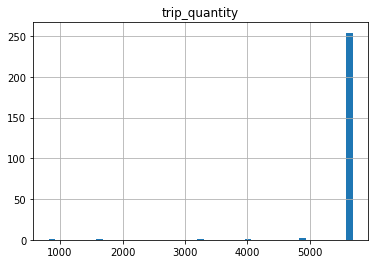

In [96]:
# num data points per item
sparsity = tts.copy()
sparsity = sparsity.groupby([item_id, location_id]).count()
sparsity[[target_value]].hist(bins=45);

In [97]:
stats = sparsity[target_value].describe()
stats

count    260.00000
mean    5631.69231
std      436.51399
min      816.00000
25%     5688.00000
50%     5688.00000
75%     5688.00000
max     5688.00000
Name: trip_quantity, dtype: float64

In [98]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# list the "dense" item combinations
sparsity.reset_index(inplace=True)
dense = sparsity.loc[(sparsity[target_value] >= stats['75%']), [item_id, location_id]].drop_duplicates()
print(dense.shape, sparsity.drop_duplicates().shape)
dense.head()

(254, 2) (260, 4)


,pulocationid,pickup_geolocation
0,1,40.68951565_-74.17678575
1,10,40.6781247_-73.79166546
2,100,40.75351409_-73.98878589
3,101,40.74372178_-73.70907059
4,102,40.70267936_-73.88199873


In [99]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# all the rest are sparse
sparse = sparsity.merge(dense, how='outer', indicator=True) \
           .query("_merge=='left_only'") \
           .drop('_merge',1)[[item_id, location_id]]
print(sparse.shape, dense.shape, sparsity.drop_duplicates().shape)
sparse.head()

(6, 2) (254, 2) (260, 4)


,pulocationid,pickup_geolocation
82,176,40.56206061_-74.11961243
94,187,40.62545372_-74.14115248
107,199,40.79204594_-73.8835364
114,204,40.54074269_-74.20697295
184,30,40.60487218_-73.82009755


In [100]:
# peek at some singletons
sparsity.loc[(sparsity[target_value] <5), [item_id, location_id]].drop_duplicates().head()

,pulocationid,pickup_geolocation


In [101]:
# # spot-check a singleton
# df.loc[((df[item_id]=="204")), :]

In [102]:
# save sparse dimensions
local_file = "sparse_fields.csv"
# Save merged file locally
sparse.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/sparse_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [103]:
# save dense dimensions
local_file = "dense_fields.csv"
# Save merged file locally
dense.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/dense_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [104]:
# restrict tts to just dense time series
tts_dense = tts.merge(dense, how="inner", on=[item_id, location_id])
print(tts_dense.shape, tts.shape)
tts_dense.sample(5)

(1444752, 4) (1464240, 4)


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
83931,2019-12-27 03:00:00,114,40.72861173_-73.99867795,29
721794,2020-01-29 18:00:00,219,40.6602285_-73.76100796,0
170246,2020-02-06 14:00:00,128,40.87218761_-73.92543209,0
111736,2019-11-30 16:00:00,119,40.83673003_-73.92696621,0
151140,2019-11-13 12:00:00,125,40.72537634_-74.00717569,72


## Step 20. Optional - Assemble and save tts.top, tts.slow <a class="anchor" id="TTS_top"></a>

In [107]:
use_location

False

In [108]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# assemble tts_top
if use_location:
    tts_top = tts.loc[(tts[item_id].isin(list(top_moving_ts[item_id].unique()))), :].copy()
else:
    tts_top = tts.loc[(tts[item_id].isin(list(top_moving_items[item_id].unique()))), :].copy()

print(tts_top.shape, tts.shape)
num_top_items = tts_top[item_id].nunique()
print(f"Number top items = {num_top_items}")
tts_top.sample(5)

Didn't drop anything.
(267336, 4) (1464240, 4)
Number top items = 47


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
177143,2019-07-29 16:00:00,137,40.74035924_-73.97711937,129
1323687,2020-01-31 06:00:00,142,40.77390599_-73.98135241,101
77369,2019-07-13 12:00:00,249,40.73461156_-74.00249691,155
963198,2019-12-03 21:00:00,262,40.77653423_-73.94582982,55
206740,2019-08-03 11:00:00,143,40.77577021_-73.98797297,123


In [109]:
# Save tts_top to S3
local_file = "tts_top.csv"
# Save merged file locally
tts_top.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_top_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [110]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# assemble tts_slow
if use_location:
    tts_slow = tts.loc[(tts[item_id].isin(list(slow_moving_ts[item_id].unique()))), :].copy()
else:
    tts_slow = tts.loc[(tts[item_id].isin(list(slow_moving_items[item_id].unique()))), :].copy()


print(tts_slow.shape, tts.shape)
num_slow_items = tts_slow[item_id].nunique()
print(f"Number slow items = {num_slow_items}")
tts_slow.sample(5)

Didn't drop anything.
(1196904, 4) (1464240, 4)
Number slow items = 213


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
592515,2019-10-04 21:00:00,5,40.55034012_-74.18992967,0
1375875,2020-02-08 16:00:00,42,40.82104621_-73.93951647,13
193433,2019-08-01 07:00:00,220,40.88190094_-73.91187726,0
134794,2019-07-22 19:00:00,255,40.71883419_-73.95713378,21
214173,2019-08-04 15:00:00,97,40.69061566_-73.97557658,4


In [111]:
# Save tts_slow to S3
local_file = "tts_slow.csv"
# Save merged file locally
tts_slow.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_slow_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [112]:
# check
assert num_slow_items + num_top_items == tts[item_id].nunique()

## Step 21. Optional - Assemble and save TTS_regular, TTS_erratic, TTS_intermittent, TTS_lumpy <a class="anchor" id="TTS_classes"></a>

In [113]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# restrict tts to just regular time series
tts_regular = tts.loc[(tts[item_id].isin(list(regular_sample[item_id].unique()))), :].copy()
# tts_reg = tts.merge(regular, how="inner", on=[item_id, location_id])

print(tts_regular.shape, tts.shape)
num_regular_items = tts_regular[item_id].nunique()
print(f"Number regular items = {num_regular_items}")
tts_regular.sample(5)

Didn't drop anything.
(767064, 4) (1464240, 4)
Number regular items = 136


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
816344,2019-11-10 03:00:00,147,40.81919853_-73.89819293,0
875696,2019-11-19 17:00:00,46,40.8474999_-73.78648631,0
179420,2019-07-30 01:00:00,101,40.74372178_-73.70907059,0
828721,2019-11-12 03:00:00,165,40.6209587_-73.95460295,0
256081,2019-08-11 10:00:00,51,40.87406155_-73.83042363,1


In [114]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# restrict tts to just erratic time series
tts_erratic = tts.loc[(tts[item_id].isin(list(erratic_sample[item_id].unique()))), :].copy()
# tts_reg = tts.merge(erratic, how="inner", on=[item_id, location_id])

print(tts_erratic.shape, tts.shape)
num_erratic_items = tts_erratic[item_id].nunique()
print(f"Number erratic items = {num_erratic_items}")
tts_erratic.sample(5)

Didn't drop anything.
(688248, 4) (1464240, 4)
Number erratic items = 121


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
652924,2019-10-14 16:00:00,186,40.74847636_-73.99245533,349
1409652,2020-02-14 04:00:00,130,40.70327388_-73.80034752,0
1429327,2020-02-17 08:00:00,181,40.67201914_-73.9790449,1
552980,2019-09-28 12:00:00,141,40.76683882_-73.95971268,310
137982,2019-07-23 08:00:00,114,40.72861173_-73.99867795,55


In [115]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# restrict tts to just intermittent time series
tts_intermittent = tts.loc[(tts[item_id].isin(list(intermittent_sample[item_id].unique()))), :].copy()
# tts_reg = tts.merge(intermittent, how="inner", on=[item_id, location_id])

print(tts_intermittent.shape, tts.shape)
num_intermittent_items = tts_intermittent[item_id].nunique()
print(f"Number intermittent items = {num_intermittent_items}")
tts_intermittent.sample(5)

Didn't drop anything.
(7296, 4) (1464240, 4)
Number intermittent items = 2


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
1355012,2020-02-05 07:00:00,30,40.60487218_-73.82009755,0
379610,2019-08-31 10:00:00,30,40.60487218_-73.82009755,0
615577,2019-10-08 15:00:00,176,40.56206061_-74.11961243,0
168272,2019-07-28 05:00:00,30,40.60487218_-73.82009755,0
1218736,2020-01-14 06:00:00,176,40.56206061_-74.11961243,0


In [116]:
# TODO - drop everything in dropped_dims
try:
    display(dropped_dims)
except:
    print("Didn't drop anything.")

# restrict tts to just lumpy time series
tts_lumpy = tts.loc[(tts[item_id].isin(list(lumpy_sample[item_id].unique()))), :].copy()
# tts_reg = tts.merge(lumpy, how="inner", on=[item_id, location_id])

print(tts_lumpy.shape, tts.shape)
num_lumpy_items = tts_lumpy[item_id].nunique()
print(f"Number lumpy items = {num_lumpy_items}")
tts_lumpy.sample(5)

Didn't drop anything.
(1632, 4) (1464240, 4)
Number lumpy items = 1


,pickup_hourly,pulocationid,pickup_geolocation,trip_quantity
400133,2019-09-03 18:00:00,199,40.79204594_-73.8835364,0
616887,2019-10-08 20:00:00,199,40.79204594_-73.8835364,0
232810,2019-08-07 16:00:00,199,40.79204594_-73.8835364,0
795034,2019-11-06 16:00:00,199,40.79204594_-73.8835364,0
1132522,2019-12-31 07:00:00,199,40.79204594_-73.8835364,0


In [118]:
# Save tts_regular to S3
local_file = "tts_regular.csv"
# Save merged file locally
tts_regular.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_regular_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [120]:
# Save tts_erratic to S3
local_file = "tts_erratic.csv"
# Save merged file locally
tts_erratic.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_erratic_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [121]:
# Save tts_intermittent to S3
local_file = "tts_intermittent.csv"
# Save merged file locally
tts_intermittent.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_intermittent_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [122]:
# Save tts_lumpy to S3
local_file = "tts_lumpy.csv"
# Save merged file locally
tts_lumpy.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_lumpy_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [123]:
# check
assert num_regular_items + num_erratic_items + num_intermittent_items + num_lumpy_items == tts[item_id].nunique()

## Step 22. Assemble and save metadata (if any) <a class="anchor" id="IM"></a>

In [124]:
# Identify metadata columns
im = df_clean[[item_id, 'pickup_borough', 'binned_max_item']].copy()
im = im.groupby(item_id).first()
im.reset_index(inplace=True)
# check nulls
display(im.isnull().sum())

print(im.shape)
if im.shape[0] < 50:
    print(im)
else:
    print(im.head())

pulocationid       0
pickup_borough     0
binned_max_item    0
dtype: int64

(260, 3)
  pulocationid pickup_borough binned_max_item
0            1            EWR           Cat_1
1           10         Queens           Cat_1
2          100      Manhattan           Cat_1
3          101         Queens           Cat_1
4          102         Queens           Cat_1


In [125]:
# check cardinality of metadata columns
im.describe()

,pulocationid,pickup_borough,binned_max_item
count,260,260,260
unique,260,6,4
top,167,Queens,Cat_1
freq,1,69,234


Additional metadata using just item target_value that is sometimes useful.

In [126]:
# # aggregate sales by item 
# synthetic = df.copy()
# synthetic = (synthetic.groupby([item_id])
#         .agg({target_value: ['max']}))

# synthetic = synthetic.reset_index()
# synthetic.sample(5)

In [127]:
# #bin data into 4 categories
# cat_scales = ["Cat_{}".format(i) for i in range(1,5)]
# synthetic['item_cat_by_max'] = list(pd.cut(synthetic[target_value]['max'].values, 4, labels=cat_scales))

# synthetic.drop(target_value, axis=1, inplace=True)
# synthetic.columns = synthetic.columns.get_level_values(0)

# print(synthetic.shape)
# print(synthetic.dtypes)
# print(synthetic.columns)
# synthetic.sample(5)

In [128]:
# synthetic.item_cat_by_max.value_counts(dropna=False)

In [129]:
# # merge synthetic features
# im = im.merge(synthetic, how="left", on=[item_id])
# print(im.shape, synthetic.shape)
# im.head()

In [130]:
# Assemble metadata

im = im.groupby(item_id).max()
im.reset_index(inplace=True)
print(im.shape)
print("checking nulls..")
print(im.isnull().sum())
im.sample(5)

(260, 3)
checking nulls..
pulocationid       0
pickup_borough     0
binned_max_item    0
dtype: int64


,pulocationid,pickup_borough,binned_max_item
14,114,Manhattan,Cat_2
208,52,Brooklyn,Cat_1
47,144,Manhattan,Cat_2
89,182,Bronx,Cat_1
4,102,Queens,Cat_1


In [131]:
# Save im to S3
local_file = "tts.csv"
# Save merged file locally
im.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.metadata.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

## Step 23. Prepare and save RTS (if any) <a class="anchor" id="RTS"></a>

Tip:  Make sure RTS does not have any missing values, even if RTS extends into future.

In [132]:
# # calculate mean sales per item per year

# temp_year_item = train_df[['year', item_id, target_value]].copy()
# temp_year_item.year = temp_year_item.year.astype(str)
# temp_year_item = temp_year_item.groupby(['year', item_id]).mean()
# temp_year_item.reset_index(inplace=True)
# temp_year_item.rename(columns={target_value:"count_year_item"}, inplace=True)
# print(temp_year_item.dtypes)
# temp_year_item.sample(2)


In [133]:
# # merge in year-item trend

# temp2 = full_history.copy()
# # temp.drop("count_day_loc_item", inplace=True, axis=1)
# print(temp2.shape)
# temp = temp2.merge(temp_year_item, how="left", on=["year", item_id])
# print(temp.shape, temp_year_item.shape)

# # check nulls
# print(temp.isna().sum())
# temp.sample(5)

In [134]:
# # Careful!!
# # Really replace full_history with merged values
# full_history = temp.copy()
# full_history.head(2)

In [135]:
# # merge in sparse or not column
# sparse['is_sparse'] = 1
# full_history['is_sparse'] = 0

# print(full_history.is_sparse.describe())
# full_history = full_history.merge(sparse, how="left", on=[item_id, location_id])
# full_history['is_sparse'] = full_history.is_sparse_y.combine_first(full_history.is_sparse_x)
# full_history.drop(['is_sparse_x', 'is_sparse_y'], inplace=True, axis=1)
# print(full_history.is_sparse.describe())
# full_history.tail()

In [136]:
# merge in top_moving or not column
# TODO: double-check this for case when locations used

full_history['top_moving'] = 0
if use_location:
    full_history.loc[(full_history[item_id].isin(top_moving_ts[item_id])
                     & (full_history[location_id].isin(top_moving_ts[location_id]))), 'top_moving'] = 1
else:
    full_history.loc[(full_history[item_id].isin(tts_top[item_id])), 'top_moving'] = 1
print(full_history.top_moving.value_counts(normalize=True, dropna=False))
print()
full_history.tail()

0   0.81923
1   0.18077
Name: top_moving, dtype: float64



,pickup_hourly,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon,pulocationid,pickup_geolocation,trip_quantity,ADI,CV,ts_type,top_moving
1522555,2020-02-29 19:00:00,Saturday,19,Saturday_19,1,0,99,40.57961795_-74.18770274,0.00000,1.16746,0.00000,regular,0
1522556,2020-02-29 20:00:00,Saturday,20,Saturday_20,1,0,99,40.57961795_-74.18770274,0.00000,1.16746,0.00000,regular,0
1522557,2020-02-29 21:00:00,Saturday,21,Saturday_21,1,0,99,40.57961795_-74.18770274,0.00000,1.16746,0.00000,regular,0
1522558,2020-02-29 22:00:00,Saturday,22,Saturday_22,1,0,99,40.57961795_-74.18770274,0.00000,1.16746,0.00000,regular,0
1522559,2020-02-29 23:00:00,Saturday,23,Saturday_23,1,0,99,40.57961795_-74.18770274,0.00000,1.16746,0.00000,regular,0


In [137]:
end_time_train

Timestamp('2020-02-22 23:00:00')

In [138]:
# zoom-in time slice so you can see patterns
df_plot = full_history.loc[((full_history[timestamp]>"2020-01-10")
                           & (full_history[timestamp]<end_time_train)
                           & (full_history[item_id].isin(random_items))), :].copy()
print(df_plot.shape, full_history.shape)
df_plot = df_plot.groupby([timestamp]).sum()
df_plot.reset_index(inplace=True)
df_plot.sample(3)

(6324, 13) (1522560, 13)


,pickup_hourly,weekend_flag,is_sun_mon,trip_quantity,ADI,CV,top_moving
997,2020-02-20 14:00:00,0,0,1064.00000,6.00000,3.59197,5
49,2020-01-12 02:00:00,6,6,1287.00000,6.00000,3.59197,5
885,2020-02-15 22:00:00,6,0,1219.00000,6.00000,3.59197,5


<AxesSubplot:>

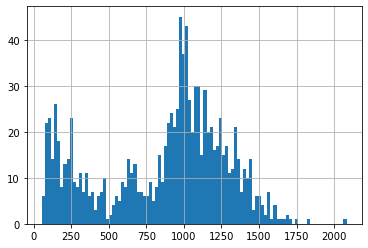

In [139]:
df_plot[target_value].hist(bins=100)

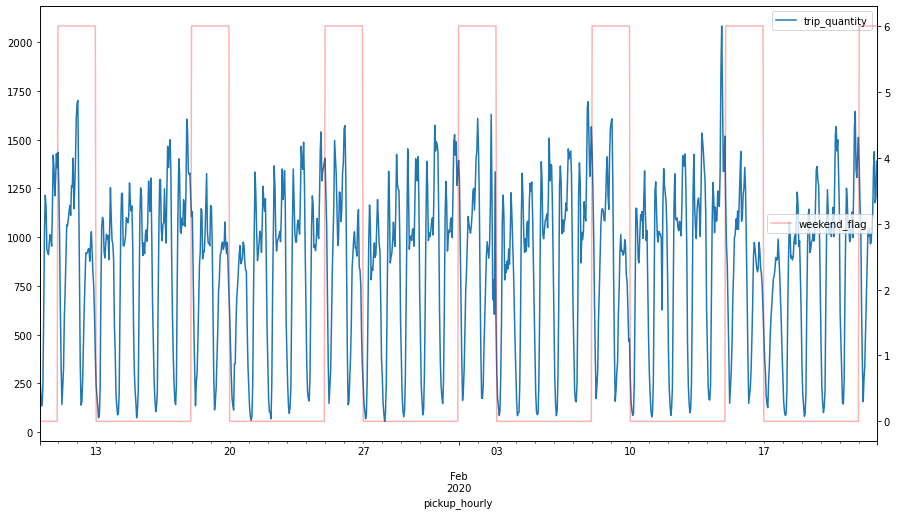

In [140]:
# Visualize candidate RTS variables
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='weekend_flag', color='red', alpha=0.3, ax=ax2);

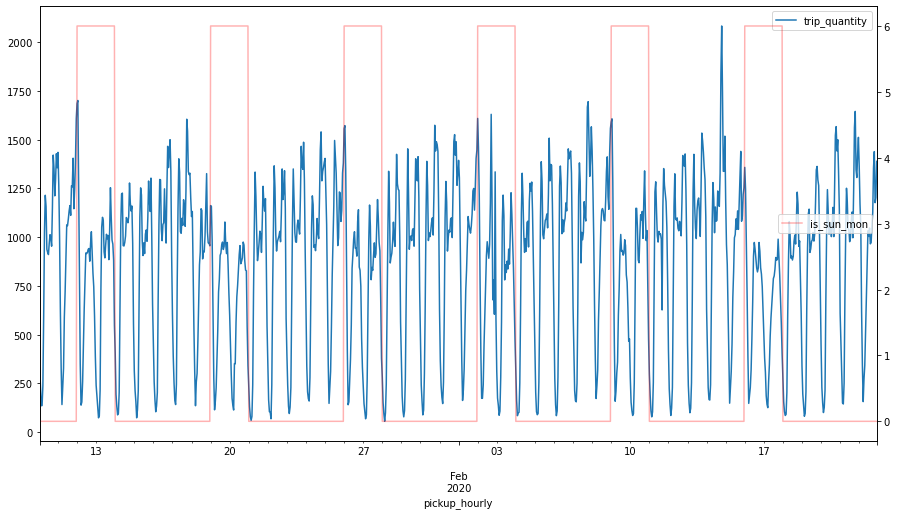

In [141]:
# Visualize candidate RTS variables is_sun_mon
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

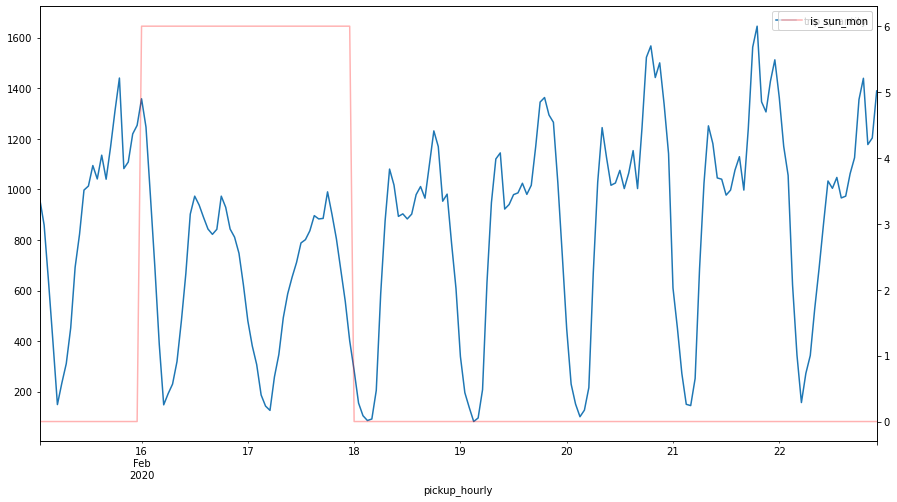

In [142]:
# Zoom-in.  Visualize candidate RTS variables is_sun_mon
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.loc[(df_plot[timestamp]>"2020-02-15"), :].plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.loc[(df_plot[timestamp]>"2020-02-15"), :].plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

It looks like lowest taxis rides are wee hours of Sunday morning through Mondays.  So it's a combination of day and hour that seems to matter, not just day of week.

In [143]:
# Assemble RTS - include whatever columns you finally decide

rts = full_history[[timestamp, item_id, location_id, 'day_hour_name']].copy()

print(rts.shape)
print(rts.isnull().sum())
print(f"rts start: {rts[timestamp].min()}")
print(f"rts end: {rts[timestamp].max()}")
rts.sample(5)

(1522560, 4)
pickup_hourly         0
pulocationid          0
pickup_geolocation    0
day_hour_name         0
dtype: int64
rts start: 2019-07-01 00:00:00
rts end: 2020-02-29 23:00:00


,pickup_hourly,pulocationid,pickup_geolocation,day_hour_name
1289415,2019-08-15 15:00:00,63,40.68481019_-73.87767643,Thursday_15
1232018,2019-10-03 02:00:00,54,40.68699115_-74.00309279,Thursday_2
266118,2019-10-17 06:00:00,142,40.77390599_-73.98135241,Thursday_6
1497434,2019-12-21 02:00:00,95,40.72346527_-73.84821994,Saturday_2
1132780,2019-10-16 04:00:00,39,40.63887893_-73.89977387,Wednesday_4


In [144]:
# Save rts to S3
local_file = "rts.csv"
# Save merged file locally
rts.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.related.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)


In [145]:
EXPERIMENT_NAME

'nyctaxi_demo2_snap02232020_168H'

In [146]:
DATA_VERSION

7

In [147]:
prefix

'open-data-analytics-taxi-trips'

In [148]:
# checkit = pd.read_csv("s3://christy-forecast/open-data-analytics-taxi-trips/v6/experiment3.related.csv")
# print(checkit.shape)
# checkit.columns = [timestamp, item_id, location_id, "day_hour_name"]
# checkit.head(2)

In [149]:
# print(checkit[timestamp].min())
# print(checkit[timestamp].max())
# print(checkit.isnull().sum())